### Implements Layer-wise Relevance Propagation for the NIST AM dataset
#### LRP-epsilon

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import os
from skimage import io, transform
import pandas as pd
import copy
import cv2
from PIL import Image as im
from torchvision.models import resnet18
import openpyxl
from matplotlib.legend_handler import HandlerTuple

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

C:\Users\satom\anaconda3\envs\autoencoder\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


cuda


In [2]:
class MeltpoolDataset(Dataset):
    """Dataset for Meltpool Images and Process Parameters"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with process parameters.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.process_parameters_frame = pd.read_excel(csv_file, sheet_name='Sheet1', header=None, engine='openpyxl')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.process_parameters_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.process_parameters_frame.iloc[idx, 0])
        image = io.imread(img_name)
        process_parameters = self.process_parameters_frame.iloc[idx,1:-1]
        process_parameters = np.array([process_parameters])
        process_parameters = process_parameters.astype('float')
        label = self.process_parameters_frame.iloc[idx, -1]
        sample = {'image': image, 'process_parameters': process_parameters, 'label': label, 'img_name': img_name}

        if self.transform:
            sample = self.transform(sample)

        return sample


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, process_parameters = sample['image'], sample['process_parameters']
        label = sample['label']
        img_name = sample['img_name']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively

        return {'image': img, 'process_parameters': process_parameters, 'label': label, 'img_name': img_name}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, process_parameters = sample['image'], sample['process_parameters']
        label = sample['label']
        img_name = sample['img_name']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                left: left + new_w]

        return {'image': image, 'process_parameters': process_parameters, 'label': label, 'img_name': img_name}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, process_parameters = sample['image'], sample['process_parameters']
        label = sample['label']
        img_name = sample['img_name']

        image = torch.from_numpy(image)
        image = torch.unsqueeze(image, dim=-1)  # Add a dimension to end to indicate a single channel
        image = image.permute((2, 0, 1))

        pp = torch.from_numpy(process_parameters)
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        #         image = image.transpose((2, 0, 1))
        return {'image': image, 'process_parameters': pp, 'label': label, 'img_name': img_name}

In [3]:
class LRP(nn.Module):

    def __init__(self, model, eps=1.0e-9, gamma=0.1):
        super().__init__()
        self.model = model
        self.model.eval()

        self.eps = eps
        self.gamma = gamma
        self.layers = self.get_layers()

    def get_layers(self):

        # Builds list of all layers in the neural network
        # Works specifically for this CNN
        layers = nn.ModuleList()
        for module in self.model.children():
            if isinstance(module, nn.Sequential):
                for module2 in module.children():
                    # for module3 in module2.children():
                    #     if isinstance(module3, nn.Sequential):
                    #         for module4 in module3.children():
                    #             layers.append(module4)
                    #     else:
                    #         layers.append(module3)
                    layers.append(module2)
            else:
                layers.append(module)
#         print(layers)
        return layers

    def evaluate(self, sample, mode='epsilon', depth=0):
        img = sample['image']
        x = img.to(device=device, dtype=torch.float)
        pp = sample['process_parameters']
        pp = pp.to(device=device, dtype=torch.float)

        act = []

        with torch.no_grad():
            act.append(torch.ones_like(x))
            for layer in self.layers:
#                 print(layer)
                if isinstance(layer, nn.Linear):
                    x = x.squeeze(dim=2)
                    x = x.squeeze(dim=2)
                x = layer(x)
                # print(x.shape)
                act.append(x)

        act = act[::-1]  # reverse order
        act = [a.requires_grad_(True) for a in act]

        R = torch.softmax(act.pop(0), dim=-1)

        R_list = []
        R_list.append(R)
        reverse_layers = self.layers[::-1]
        for layer in reverse_layers:
            if mode is 'epsilon':
                R = self.lrp_eval_eps(layer, act.pop(0), R)
                R_list.append(R)
            elif mode is 'gamma':
                R = self.lrp_eval_gamma(layer, act.pop(0), R)
                R_list.append(R)
        return R_list[-1-depth]

    def lrp_eval_eps(self, layer, a, R):
        if isinstance(layer, nn.Linear):
            a = a.squeeze(dim=2)
            a = a.squeeze(dim=2)

        if isinstance(layer, nn.ReLU):
            return R

        a = a.data.requires_grad_(True)
        z = self.eps + layer.forward(a)
        s = (R / (z + 1e-9)).data  # 1e-9 to prevent divide by 0
        (z * s).sum().backward()
        c = a.grad
        R = a * c
        return R
    
    def lrp_eval_gamma(self, layer, a, R):
        if isinstance(layer, nn.Linear):
            a = a.squeeze(dim=2)
            a = a.squeeze(dim=2)

        if isinstance(layer, nn.ReLU):
            return R
        elif isinstance(layer, nn.AdaptiveAvgPool2d):
            return R
        
        a = a.data.requires_grad_(True)
        newLayer = self.gamma_rho(layer)
        z = self.eps + newLayer.forward(a)
        s = (R / (z + 1e-9)).data  # 1e-9 to prevent divide by 0
        (z * s).sum().backward()
        c = a.grad
        R = a * c
        return R
    
    def gamma_rho(self, layer):
        zero = torch.zeros_like(layer.weight)
        w_plus = torch.max(zero, layer.weight)
        rho = layer.weight + self.gamma*w_plus
        rho = nn.parameter.Parameter(rho)
        newLayer = copy.deepcopy(layer)
        newLayer.weight = rho
        return newLayer

In [4]:
meltpool_dataset_train = MeltpoolDataset('Preprocessed Images/sorted/TestPP_normalized_01_27_23.xlsx', 'Preprocessed Images/sorted/test/',
                                         transform=transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))
dataloader = DataLoader(meltpool_dataset_train, batch_size=1, shuffle=True, num_workers=0)

In [5]:
num_classes = 8
num_param = 0

PATH = 'trained_models/ImageCNNResNetepoch50.pth'

torch.cuda.empty_cache()

eps = 1

lrp_model = resnet18()
lrp_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
lrp_model.fc = nn.Linear(512, num_classes)
lrp_model.load_state_dict(torch.load(PATH))
lrp_model.to(device)
lrp_model.eval()

lrp = LRP(lrp_model, eps=eps)

### LRP on Image Input 

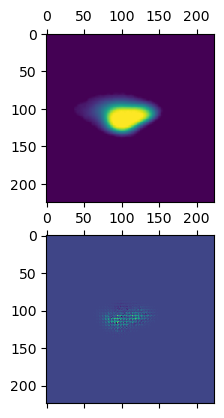

In [6]:
data_iter = iter(dataloader)
sample = next(data_iter)
sample2 = next(data_iter)

R=lrp.evaluate(sample, mode='epsilon', depth=0)

img = sample['image']
img = img.numpy().squeeze()
fig, axs = plt.subplots(2)
axs[0].matshow(img)
axs[1].matshow(R.cpu().detach().numpy().squeeze())
plt.show()

### LRP on 1st Hidden Layer

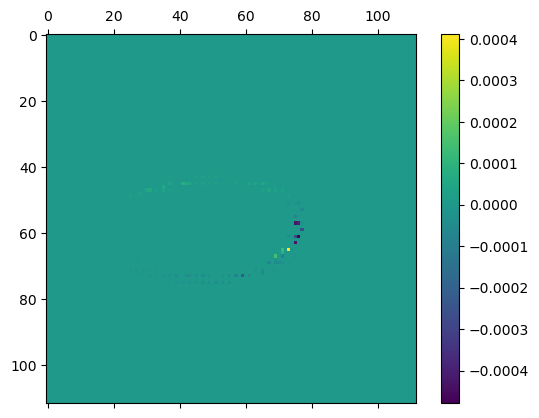

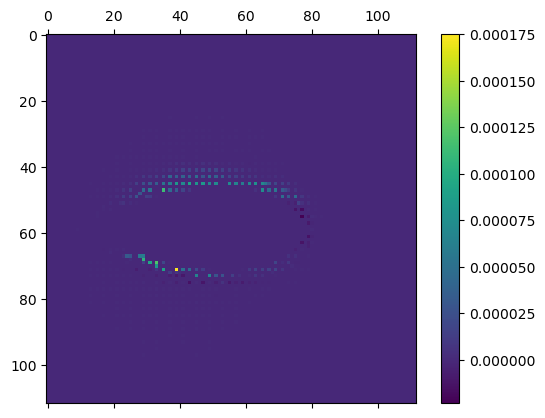

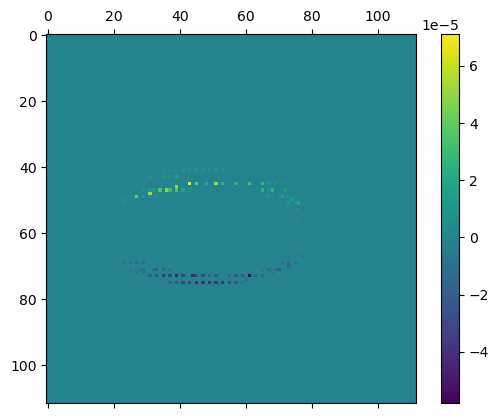

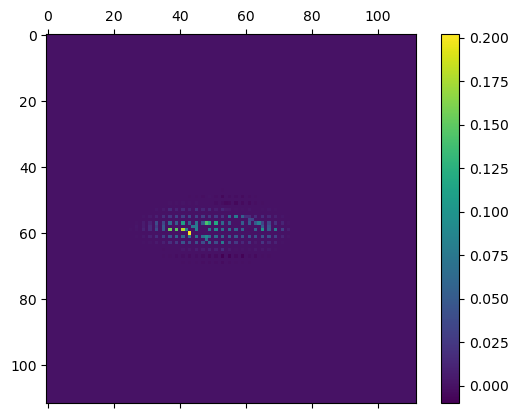

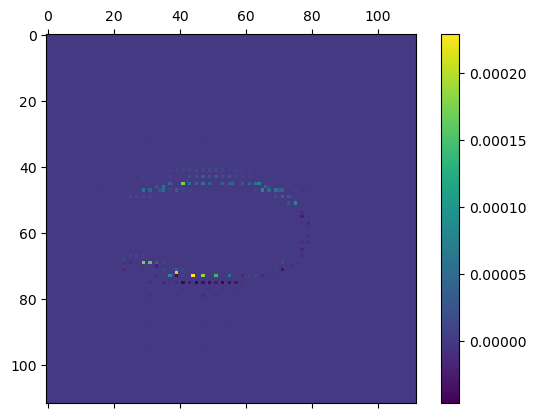

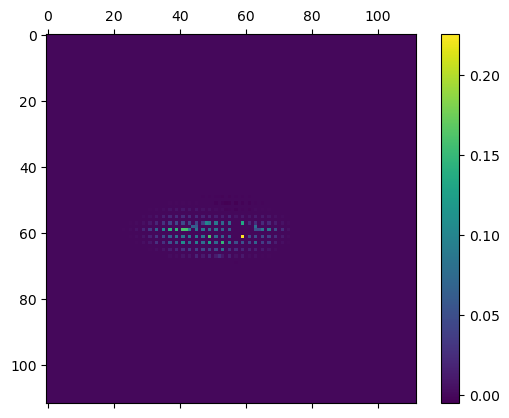

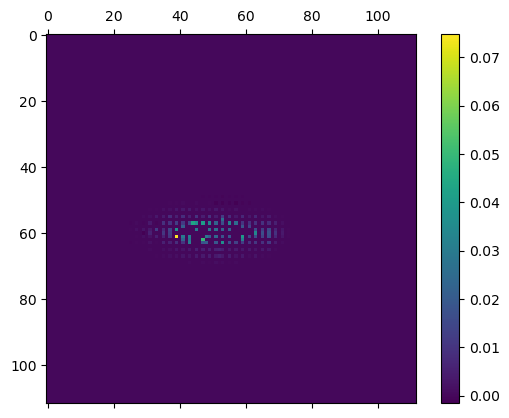

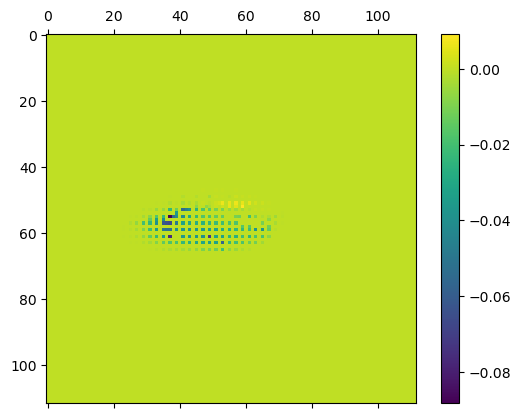

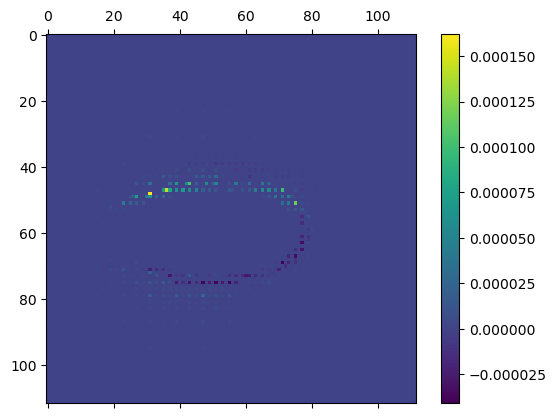

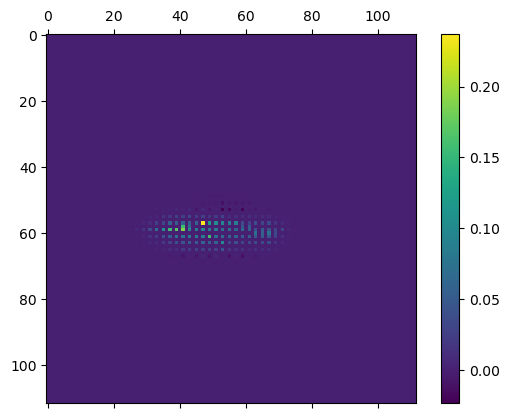

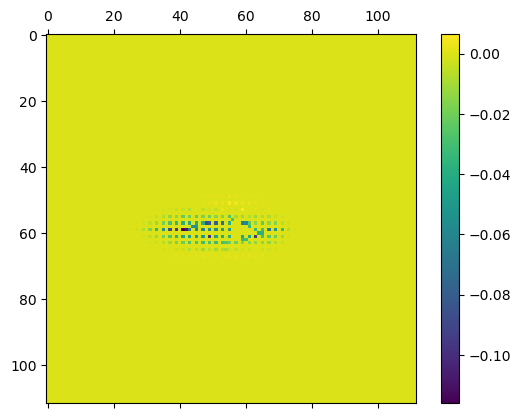

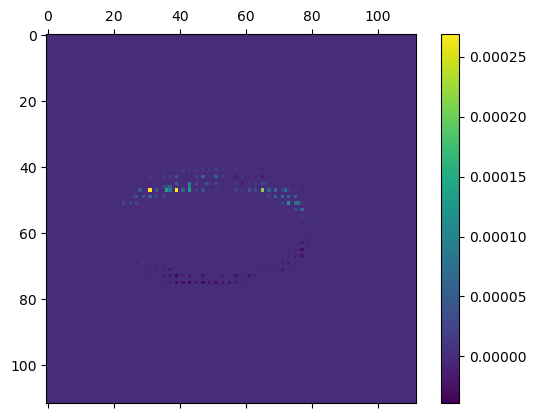

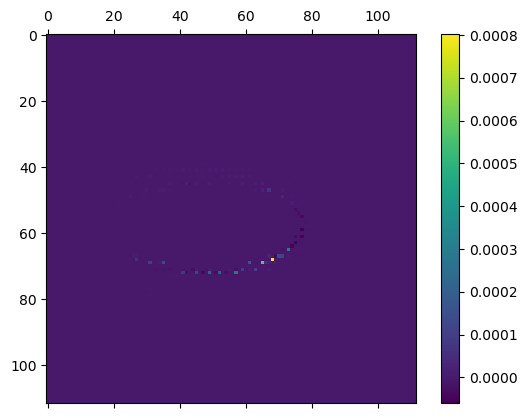

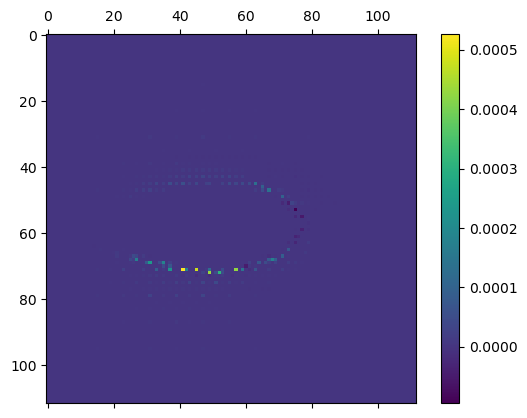

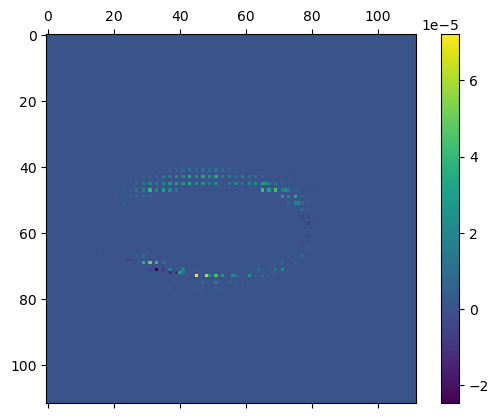

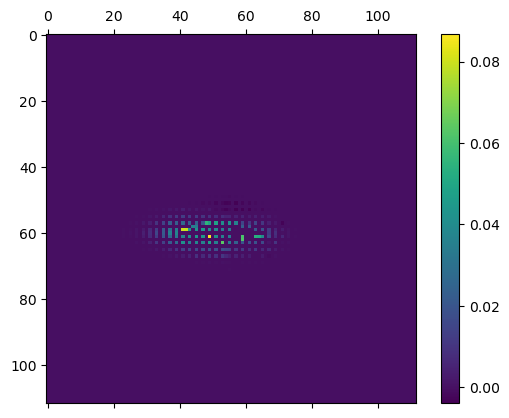

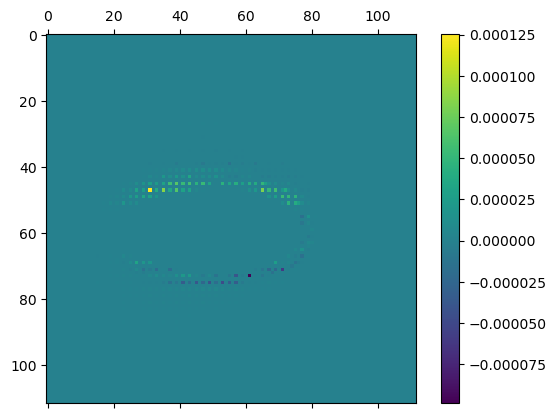

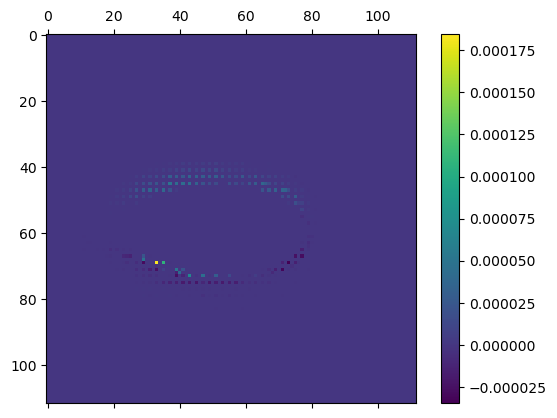

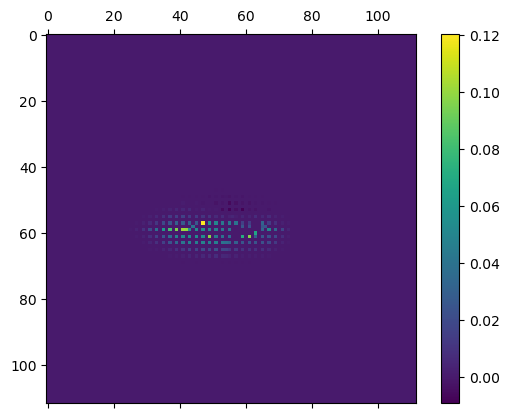

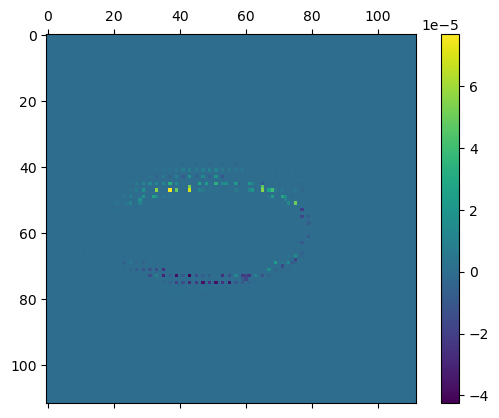

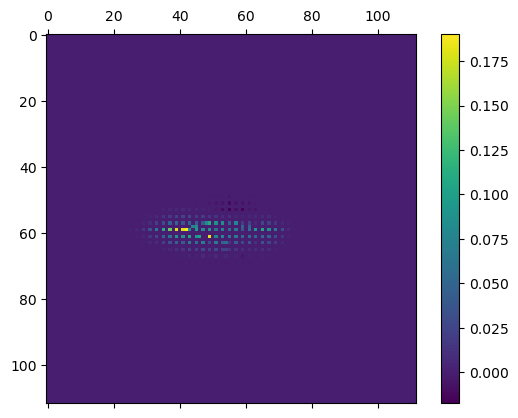

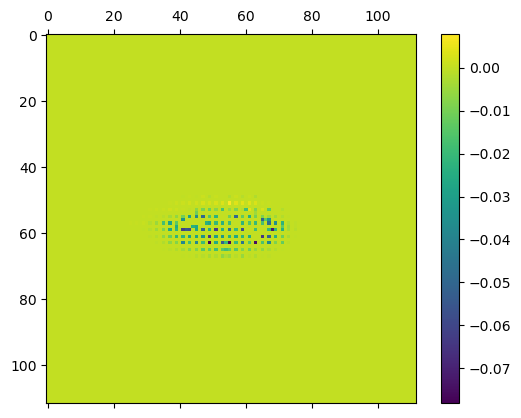

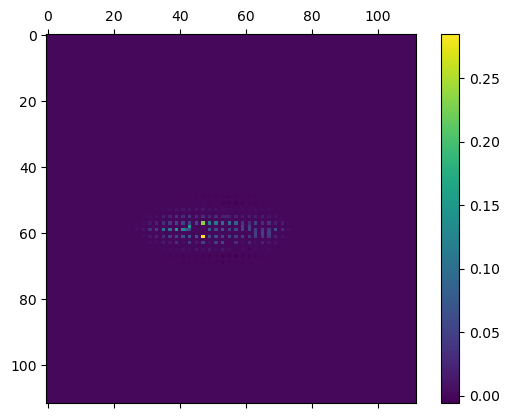

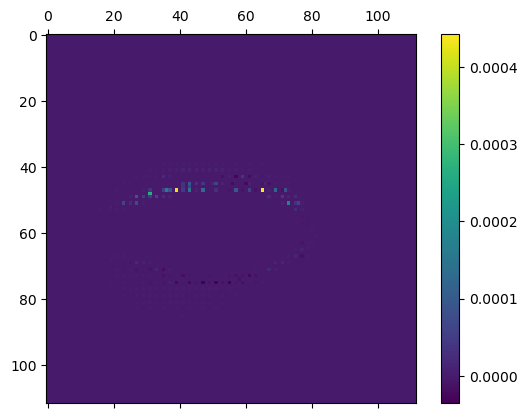

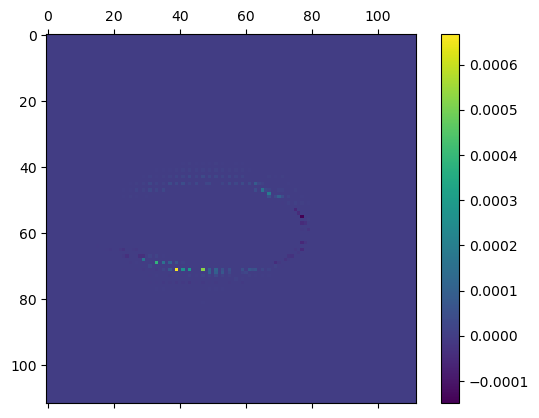

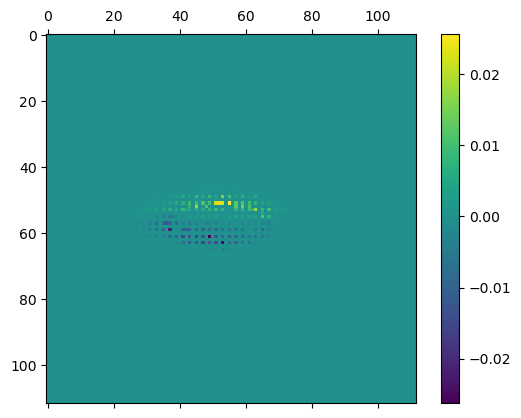

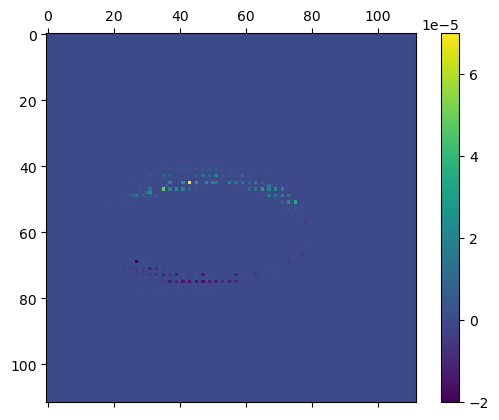

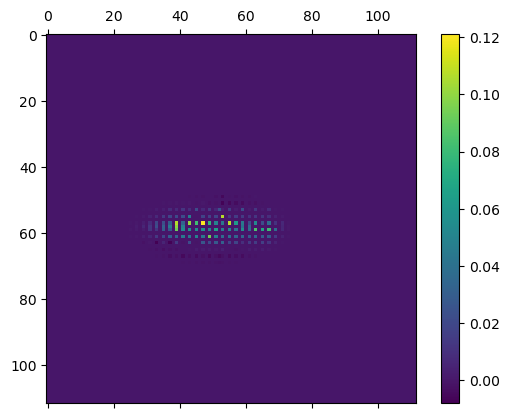

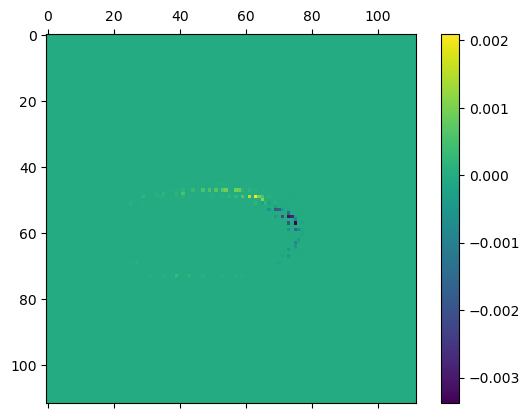

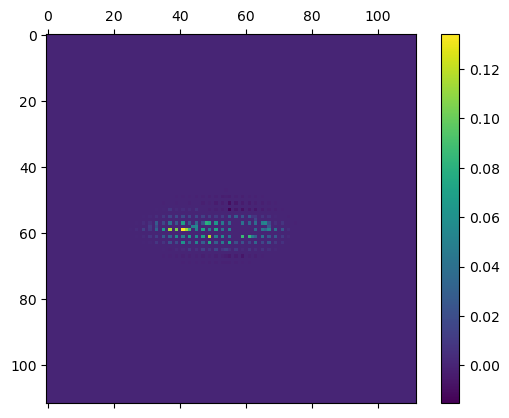

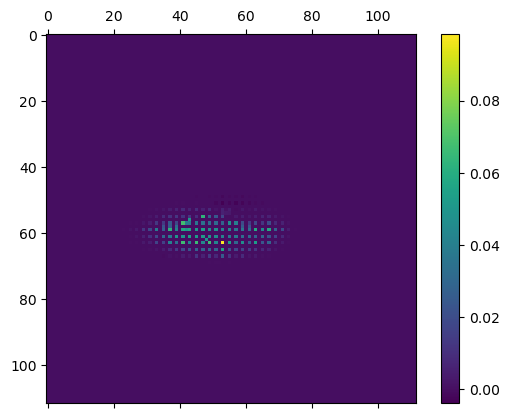

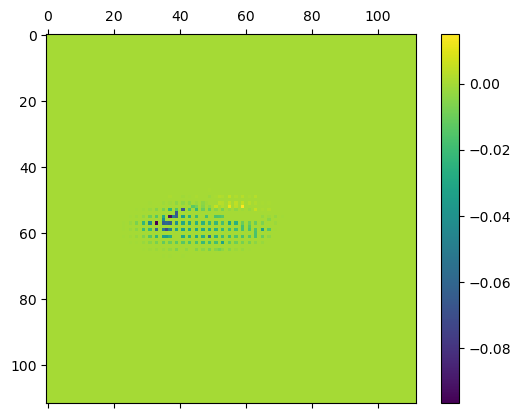

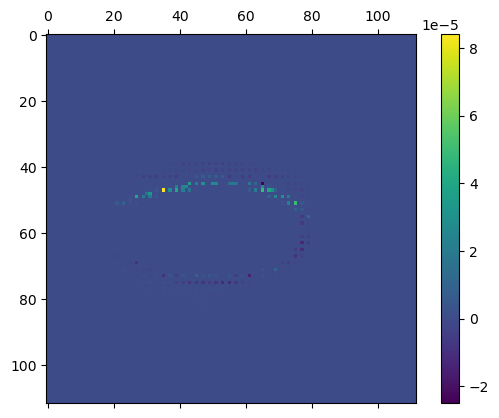

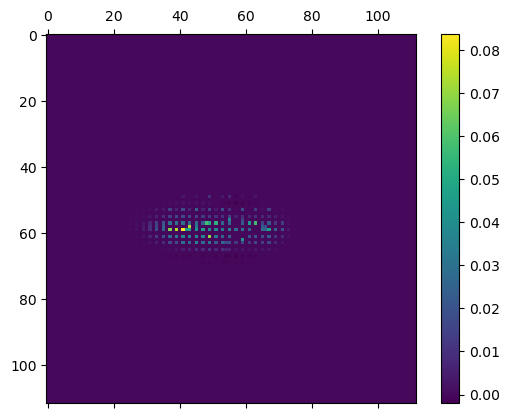

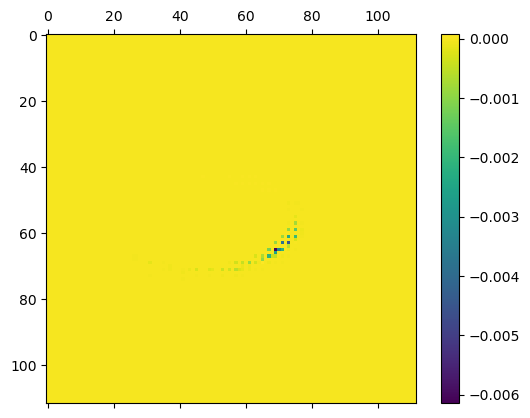

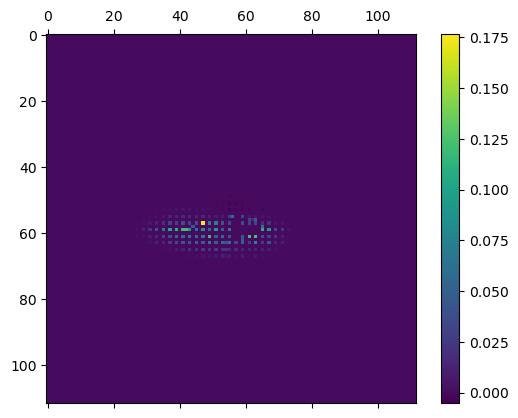

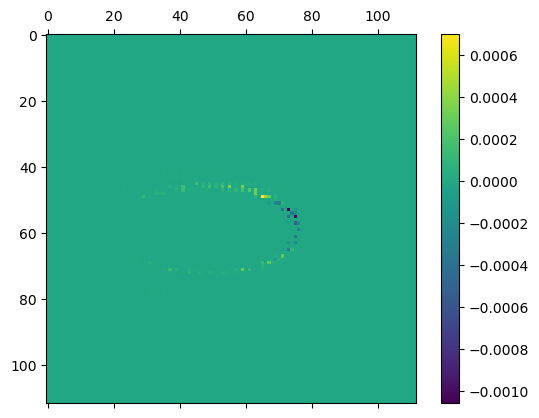

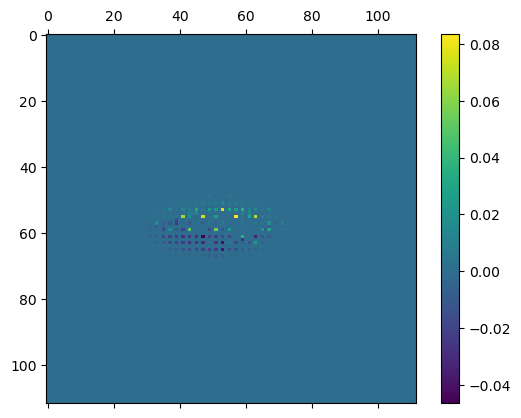

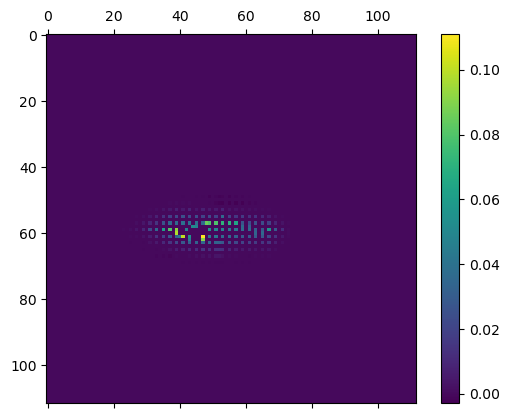

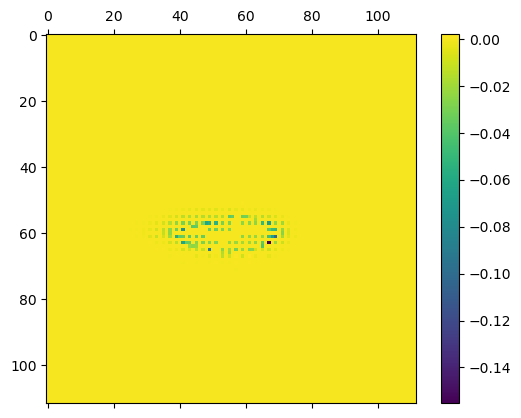

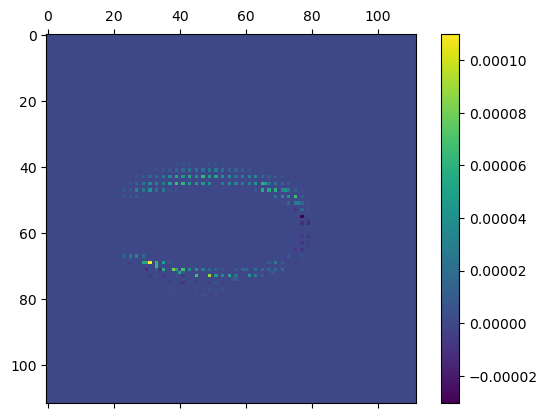

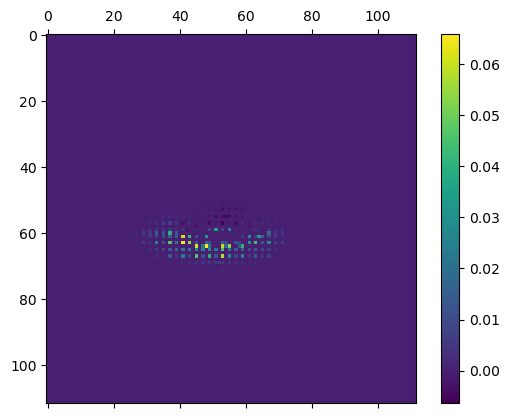

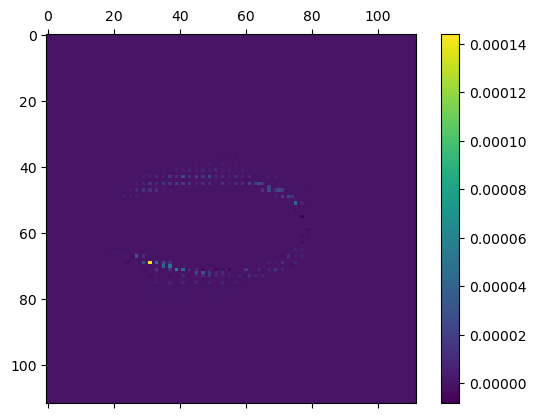

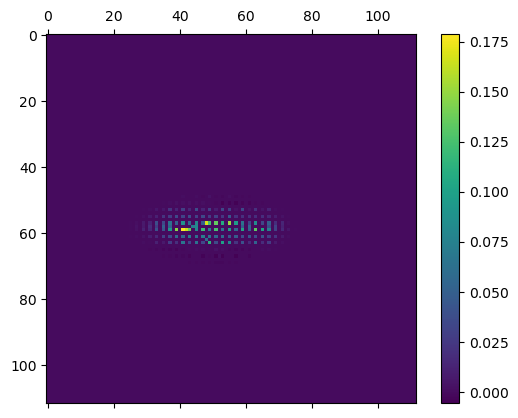

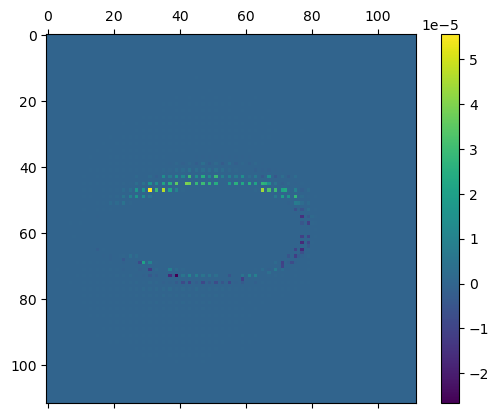

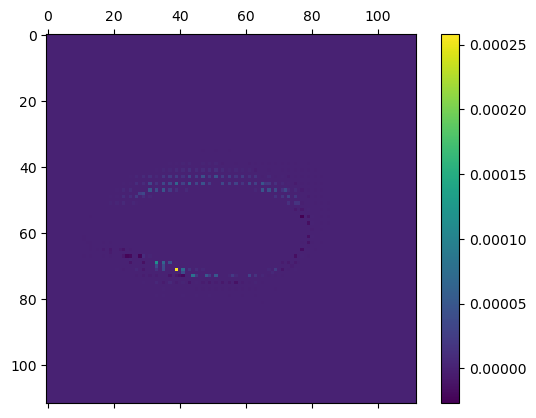

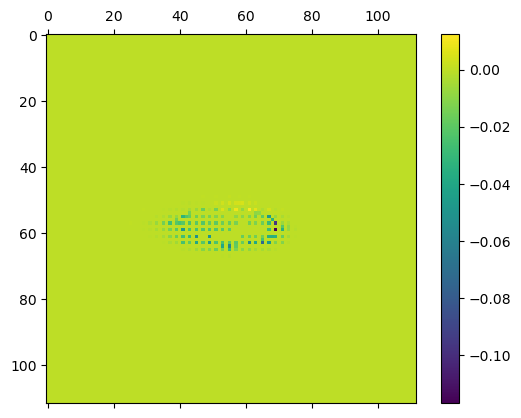

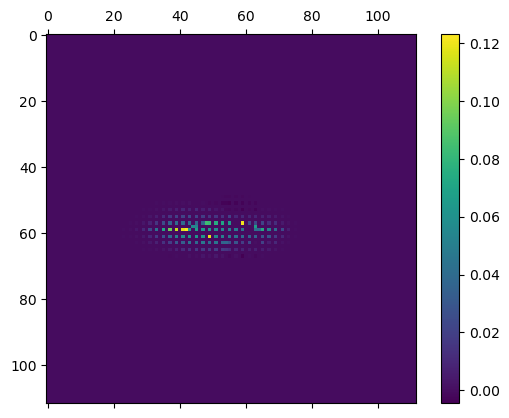

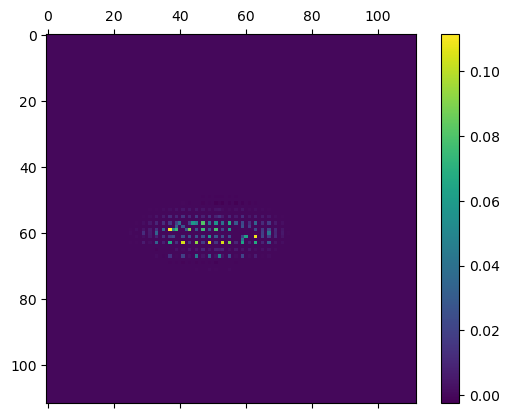

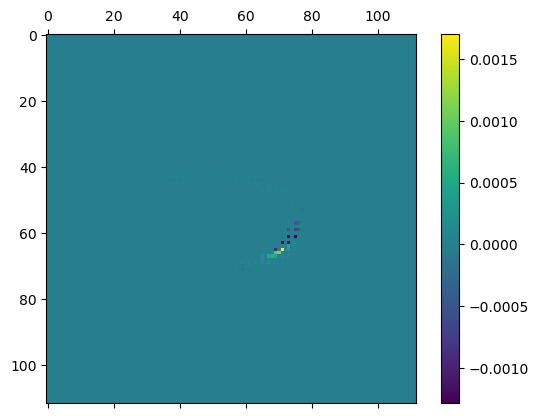

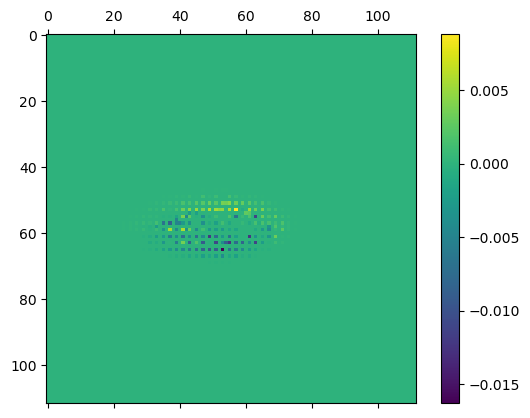

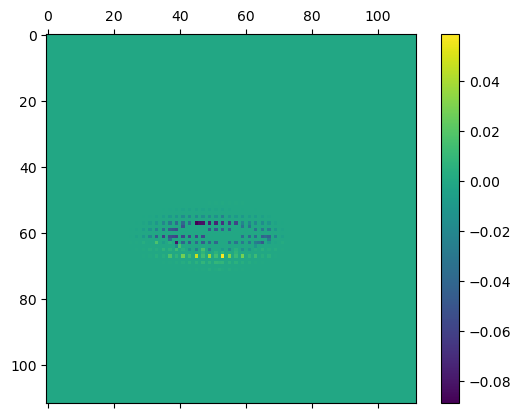

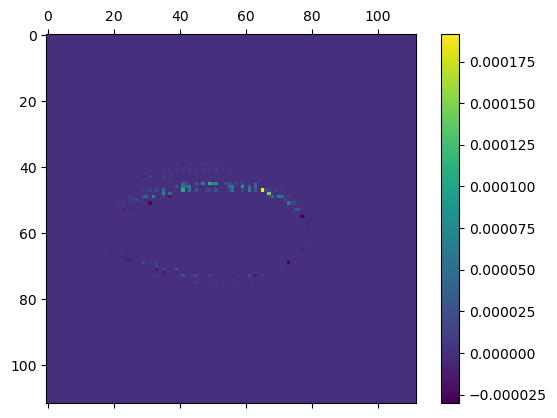

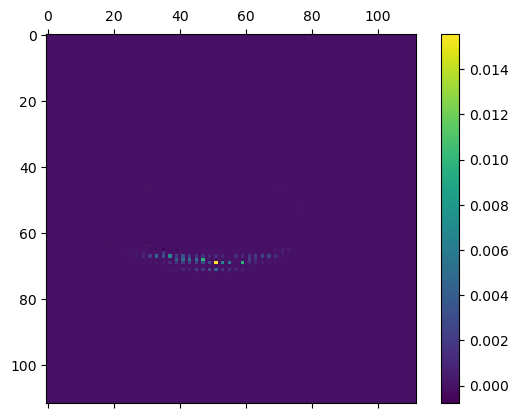

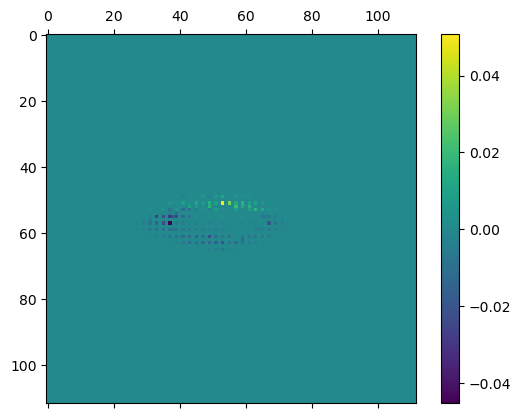

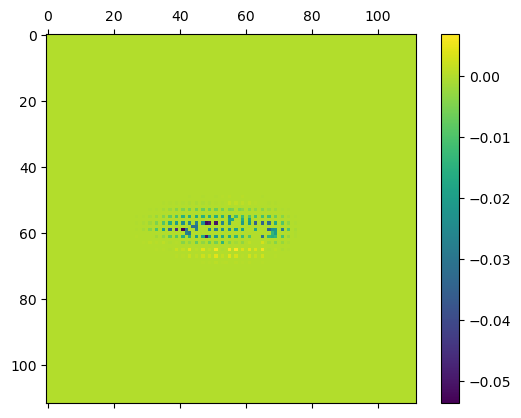

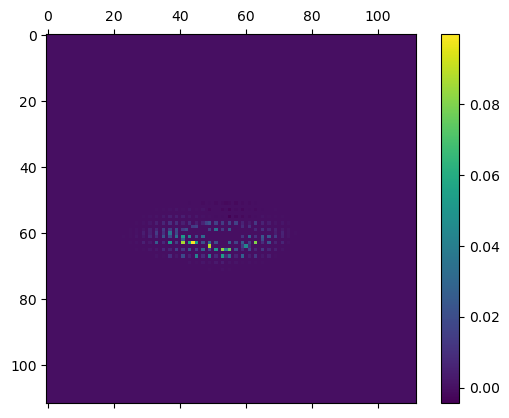

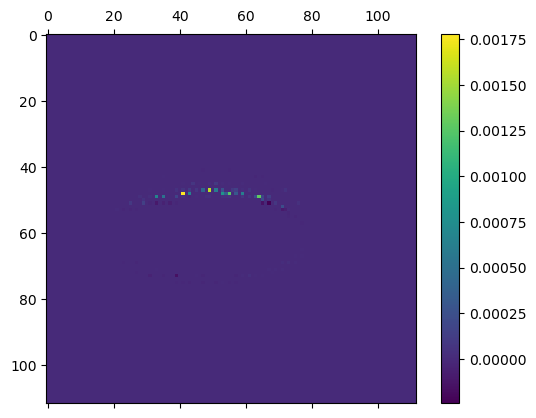

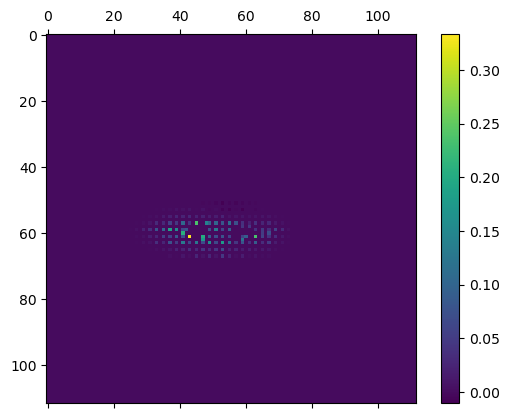

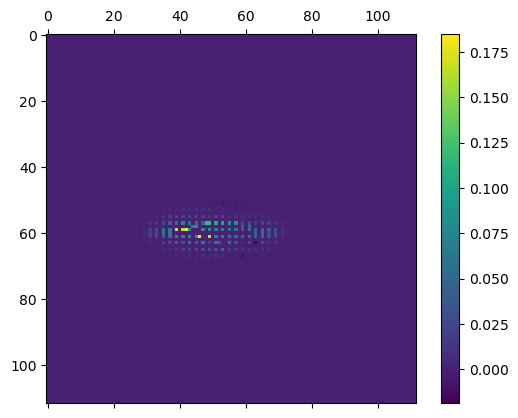

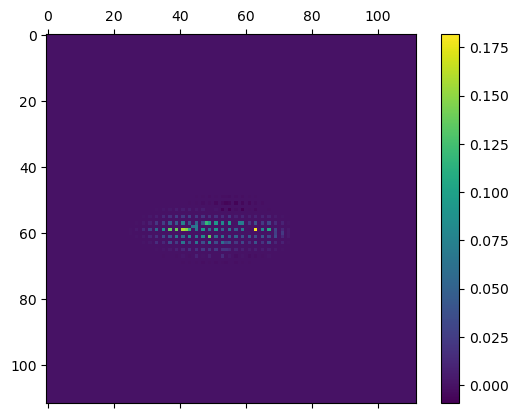

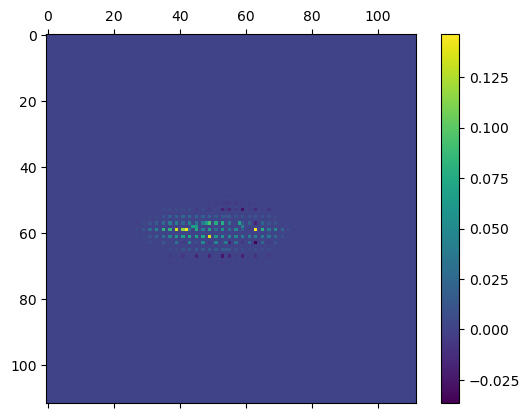

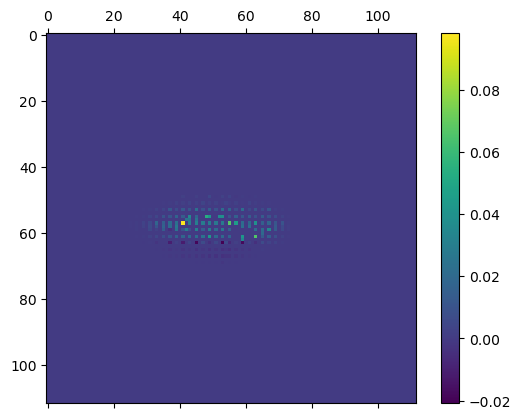

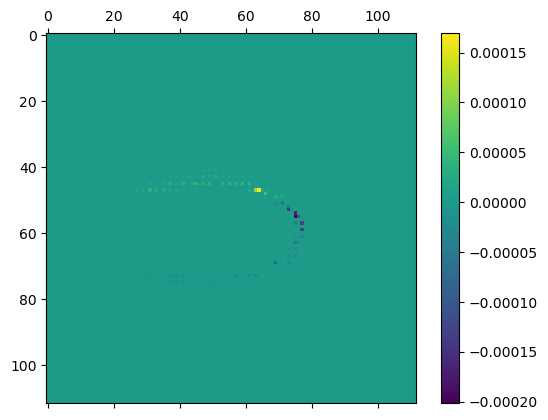

In [7]:
R=lrp.evaluate(sample, mode='epsilon', depth=2)
R.shape

R_sum = np.zeros((112,112))

for ii in range(64):
    fig, axs = plt.subplots()
    heatmap = axs.matshow(R[:,ii,:,:].cpu().detach().numpy().squeeze())
    cbar = fig.colorbar(heatmap, ax=axs)
    plt.show()
    
    R_sum += R[:,ii,:,:].cpu().detach().numpy().squeeze()

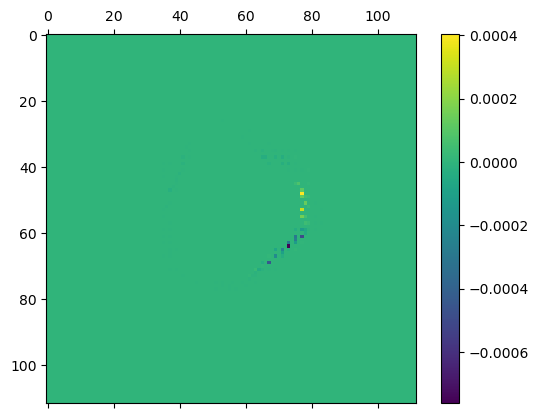

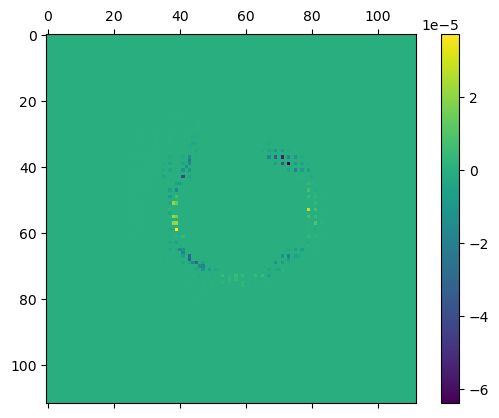

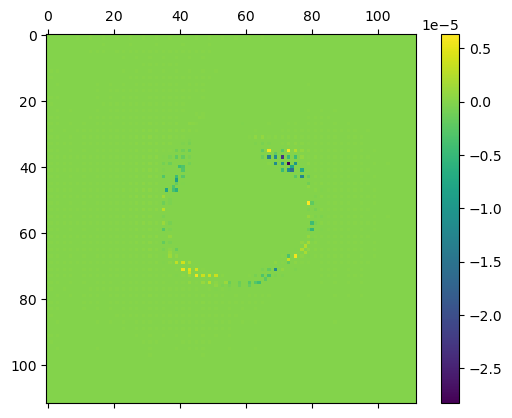

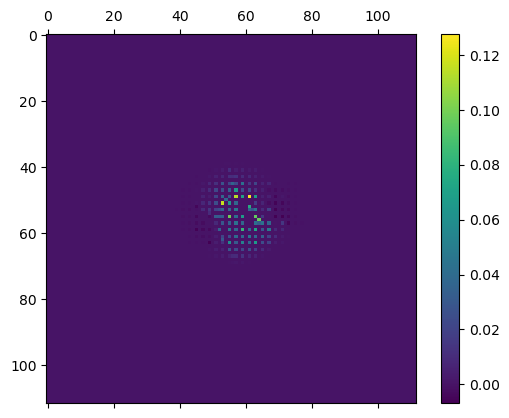

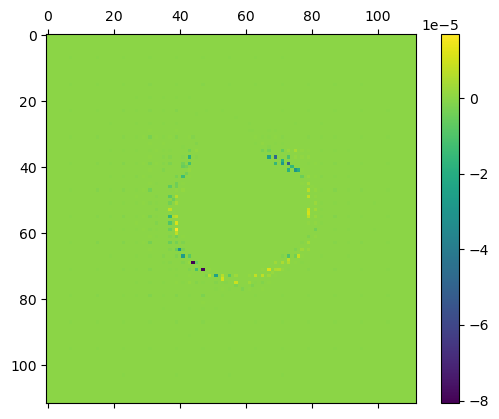

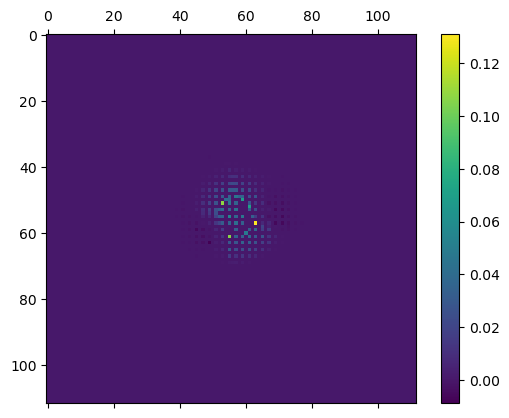

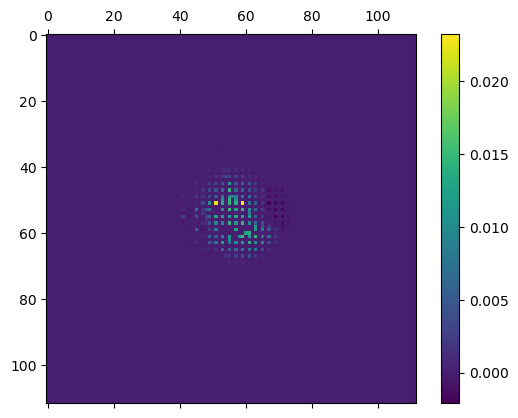

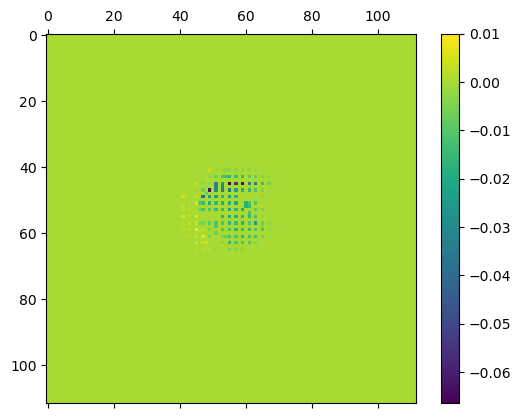

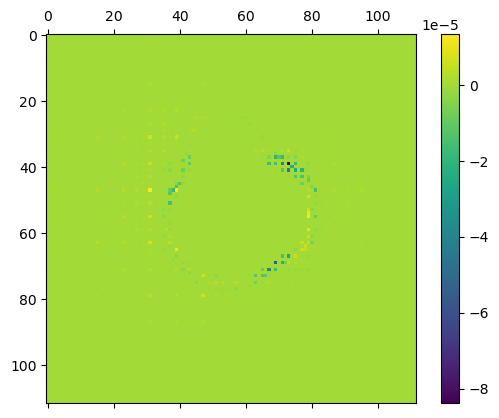

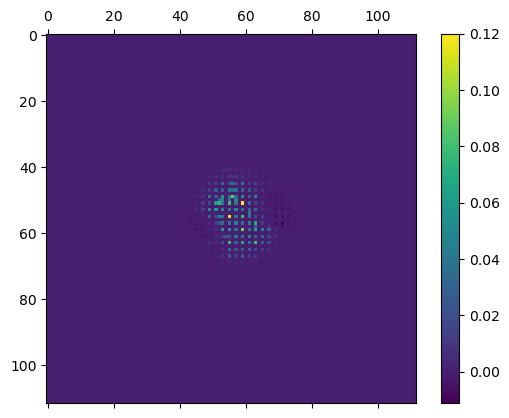

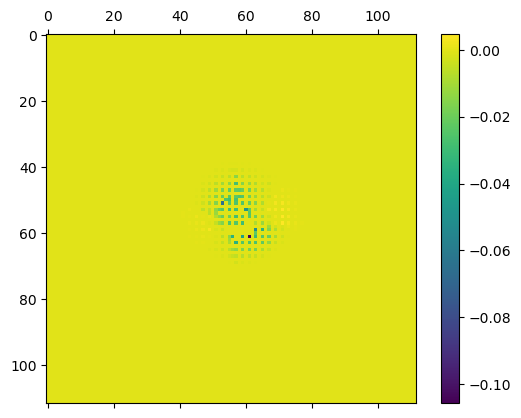

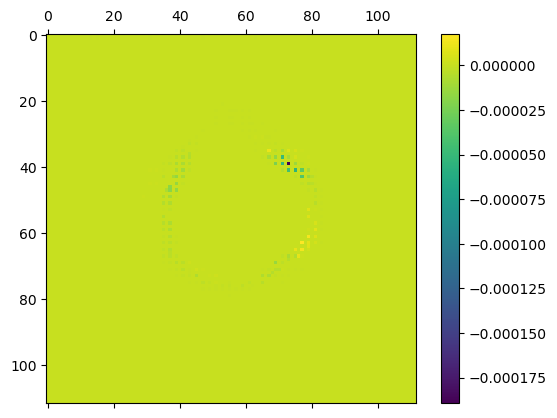

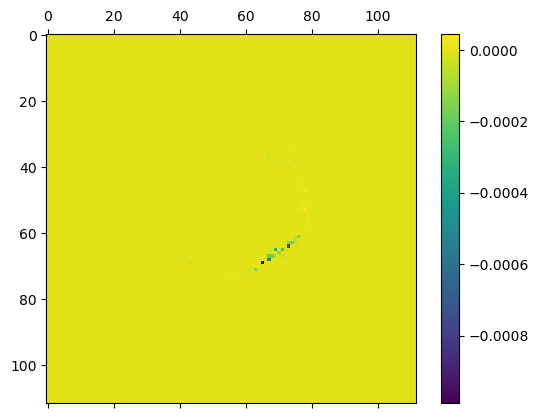

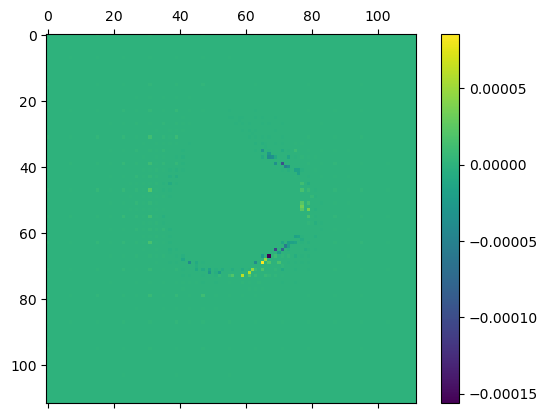

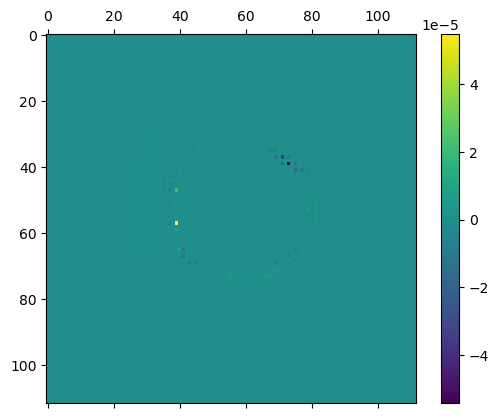

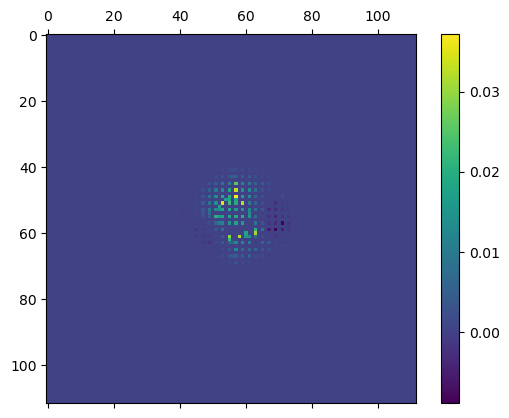

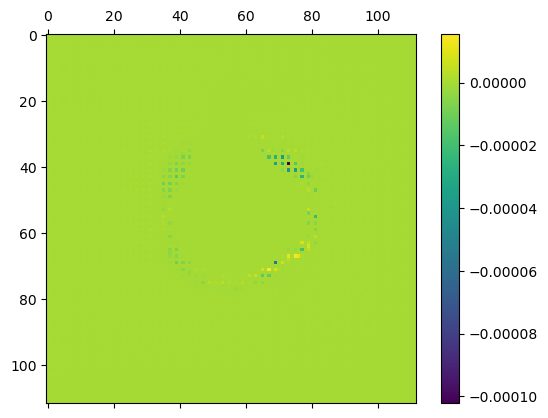

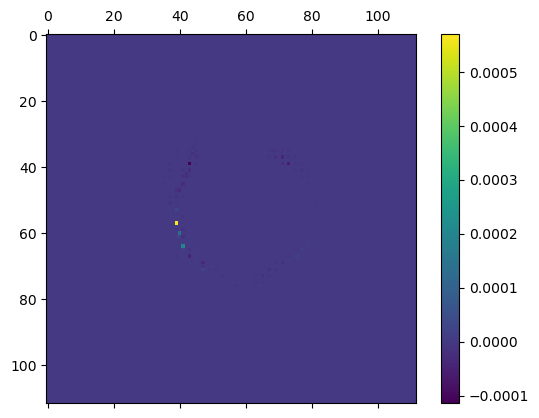

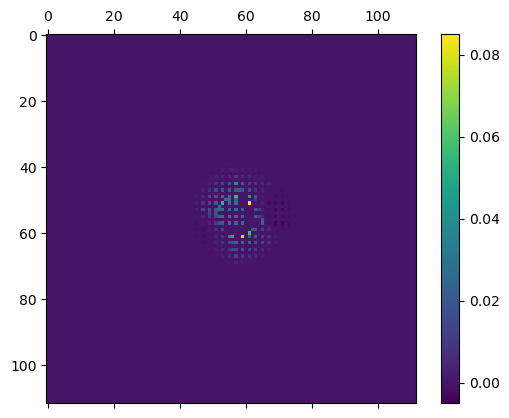

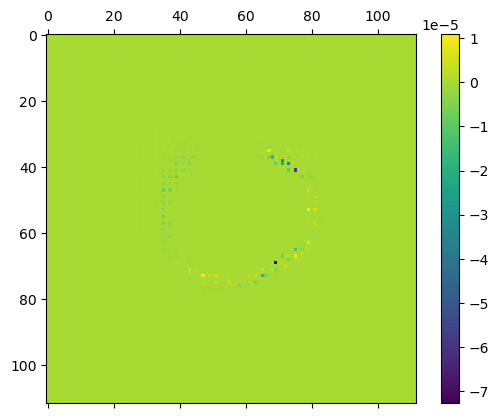

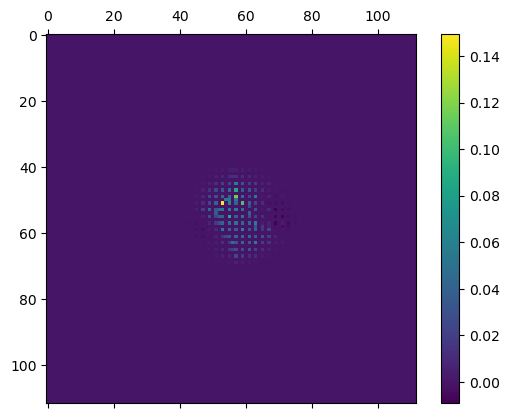

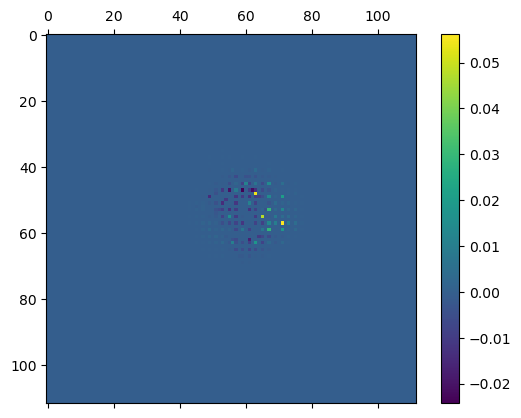

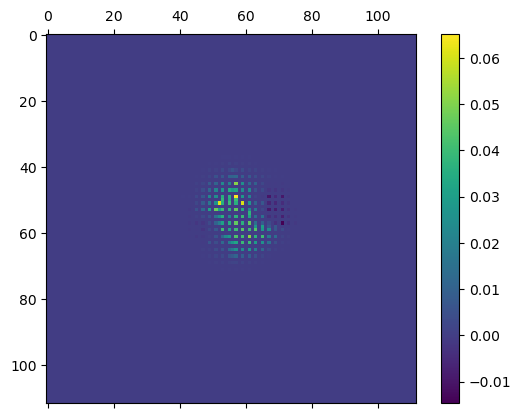

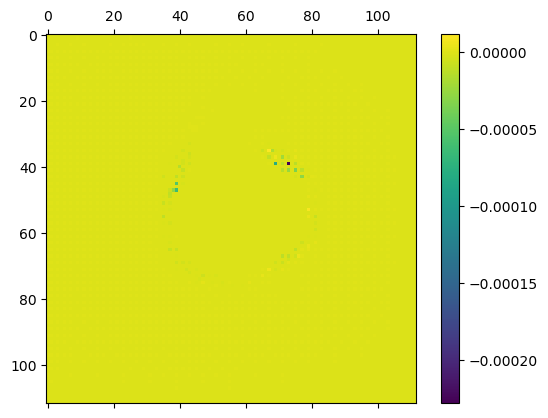

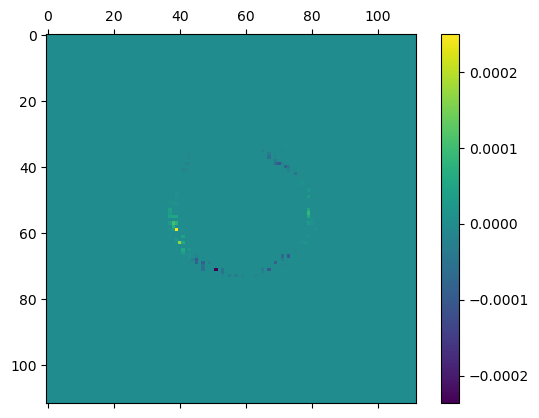

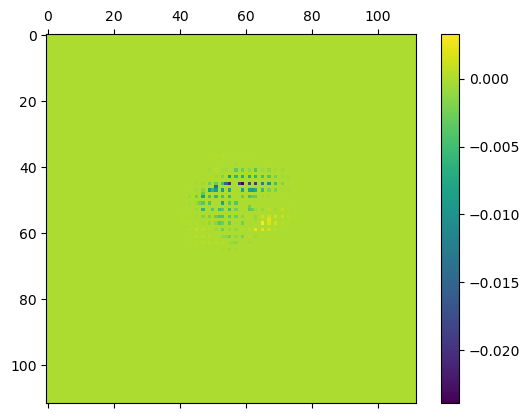

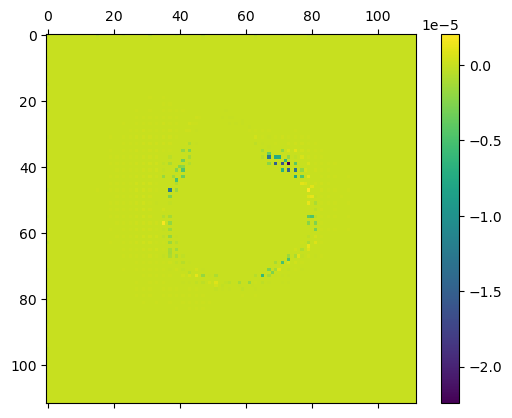

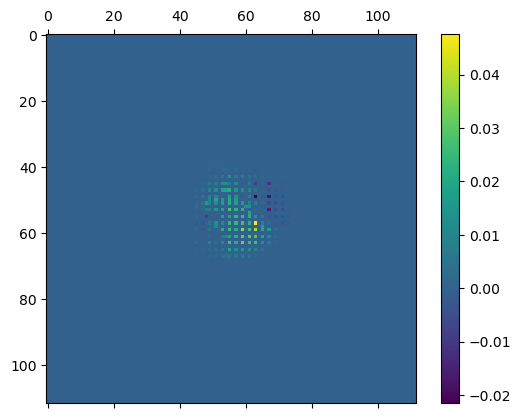

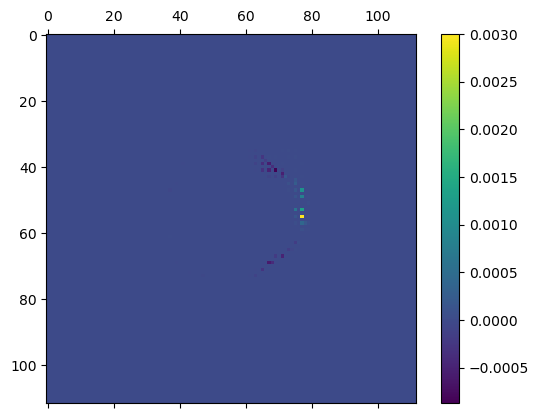

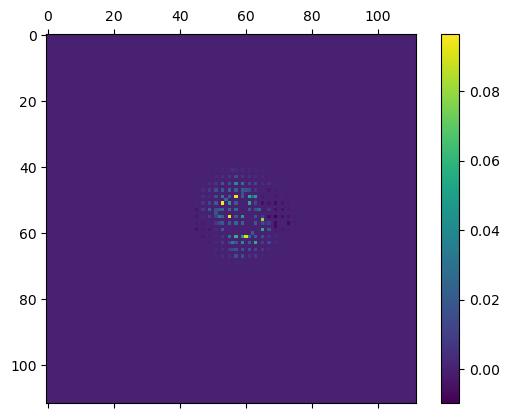

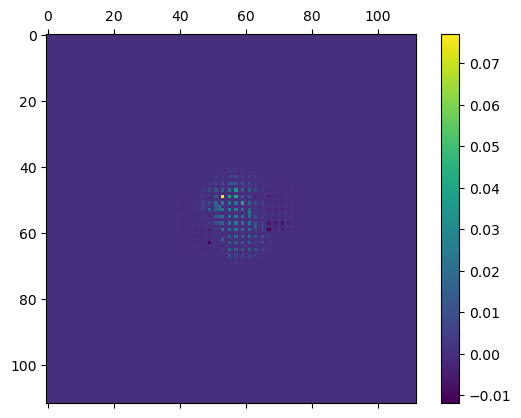

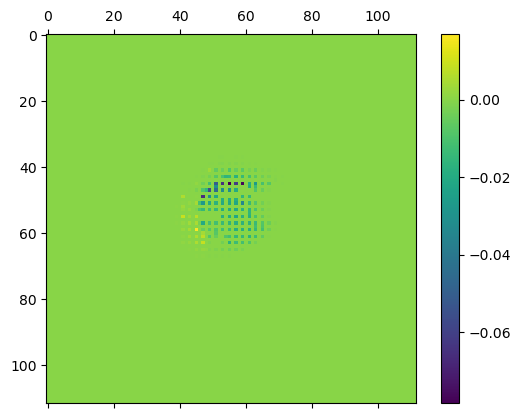

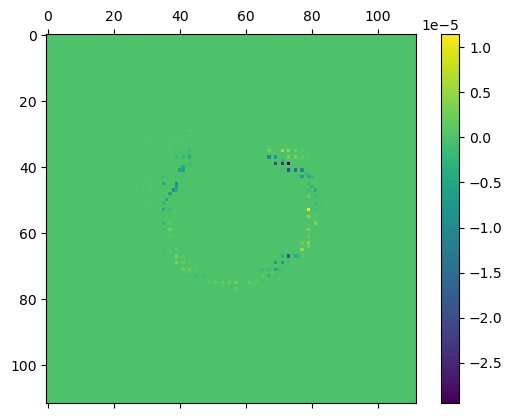

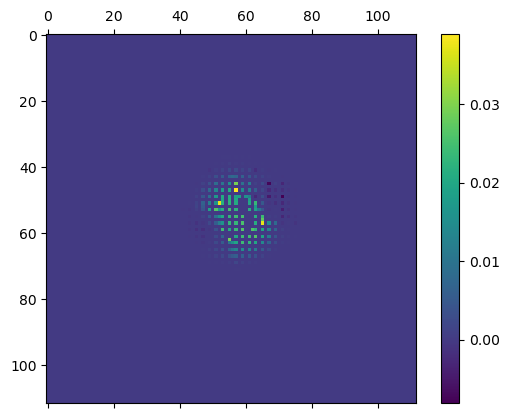

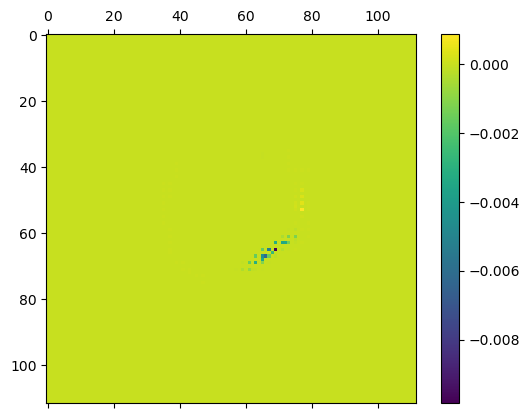

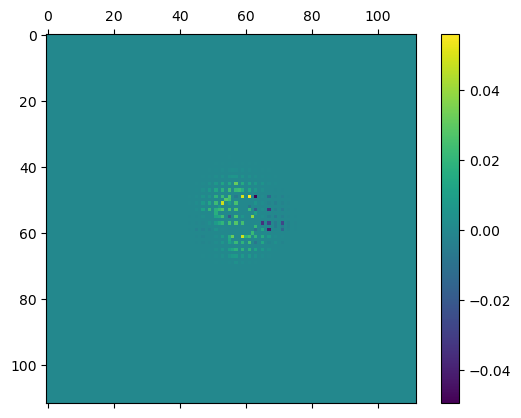

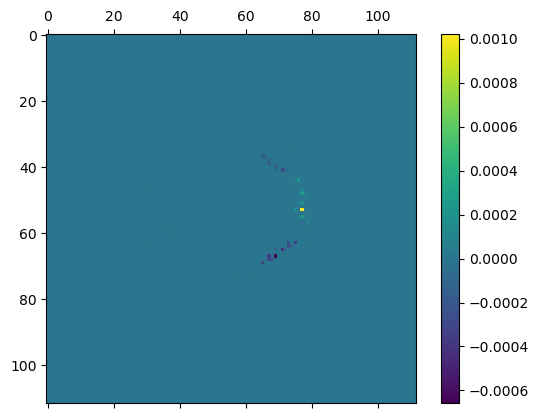

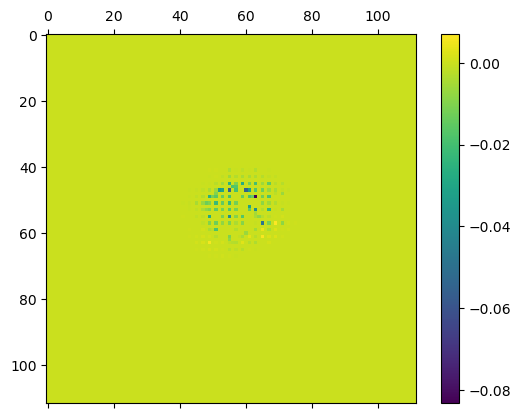

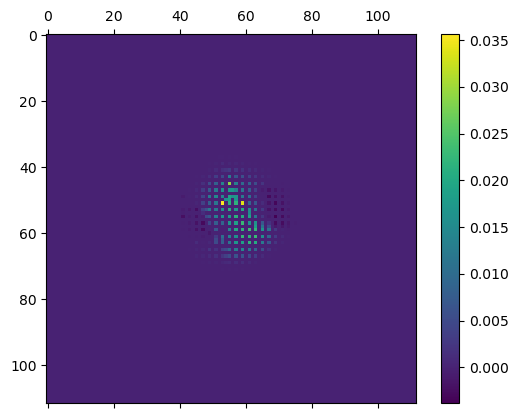

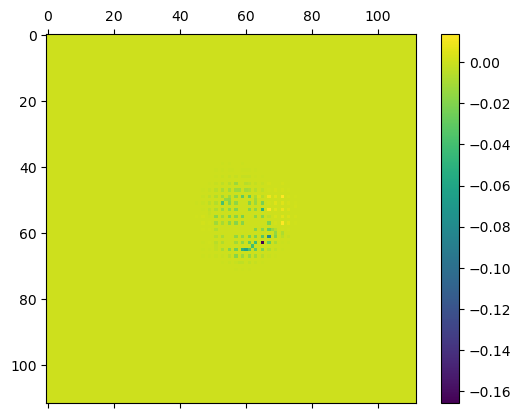

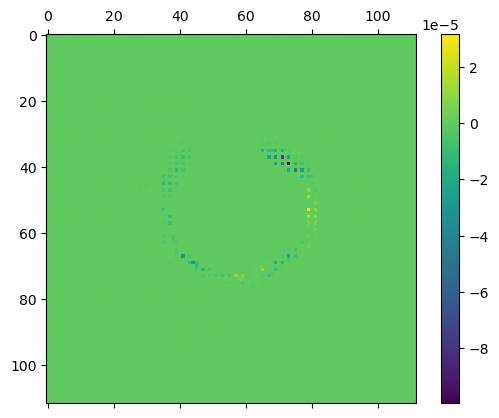

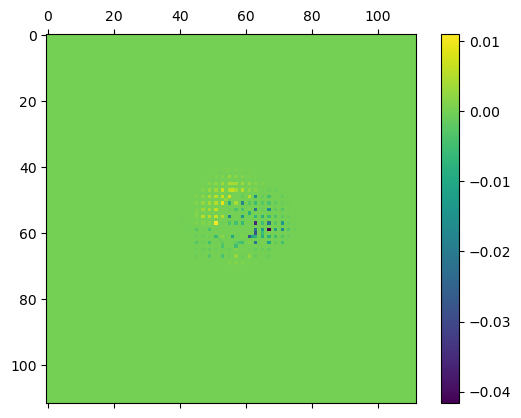

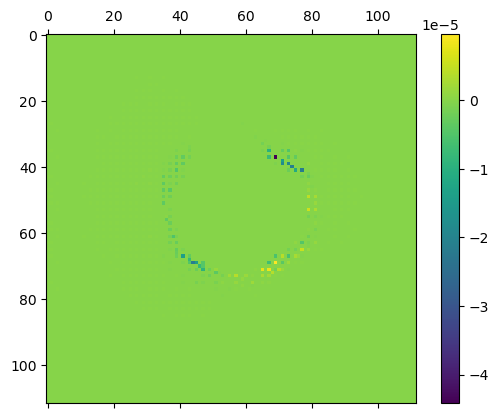

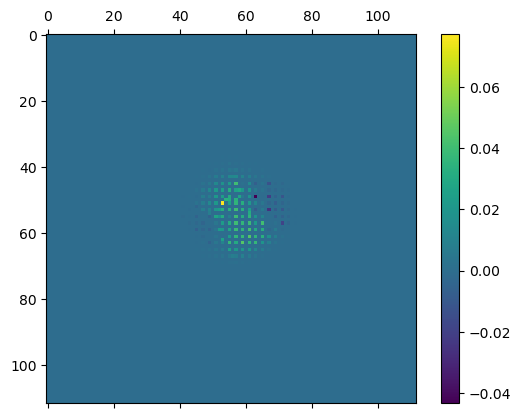

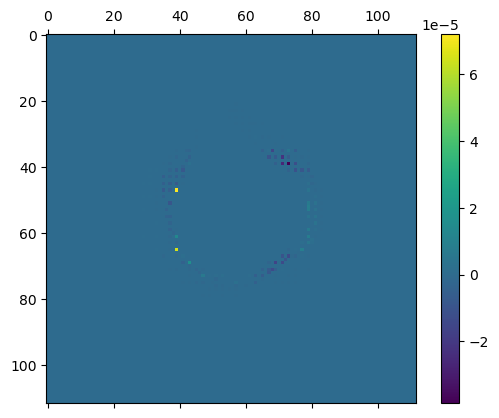

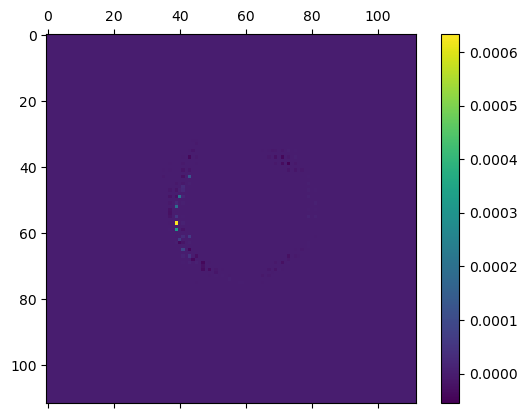

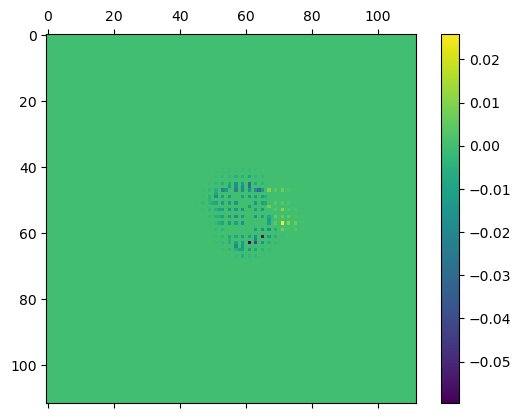

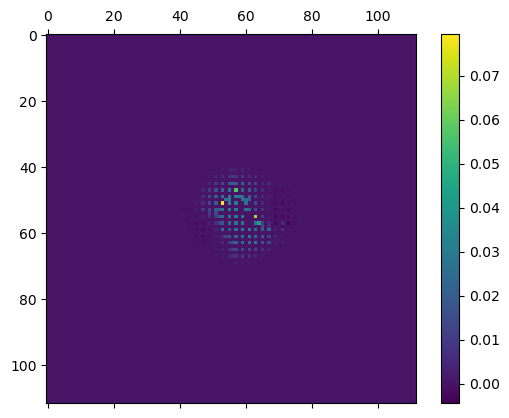

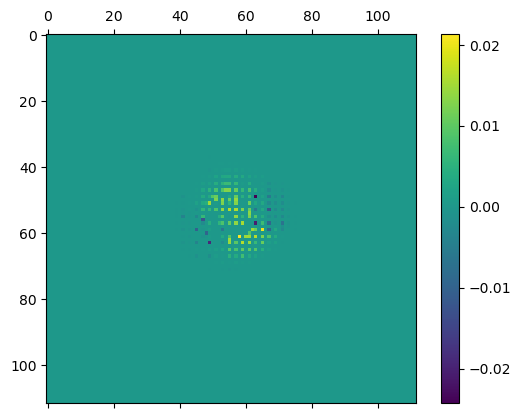

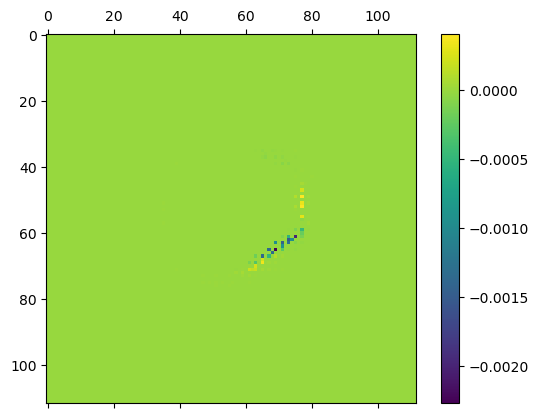

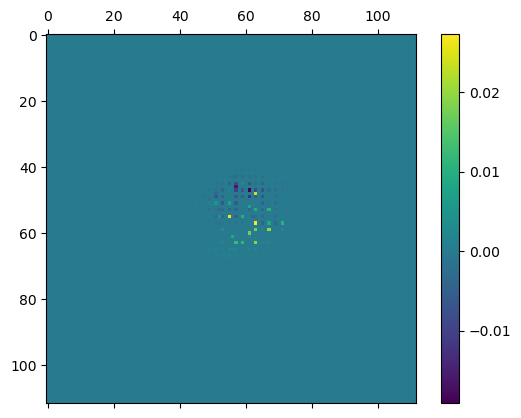

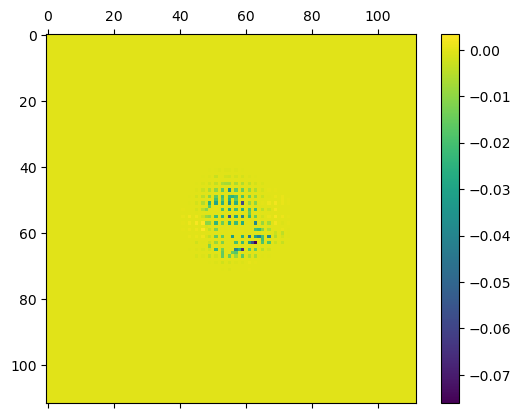

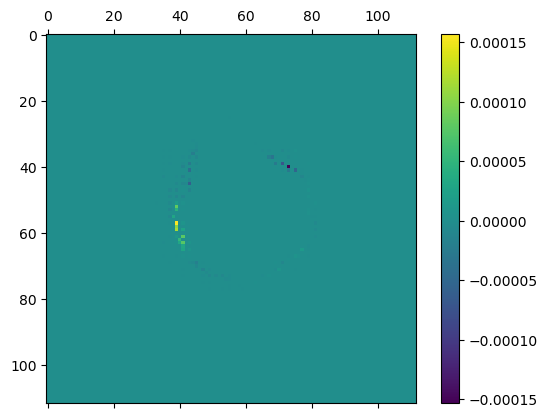

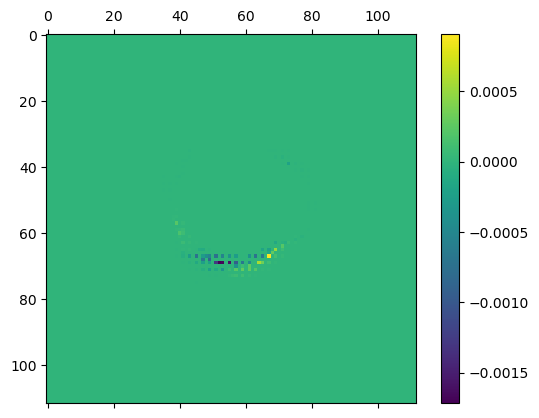

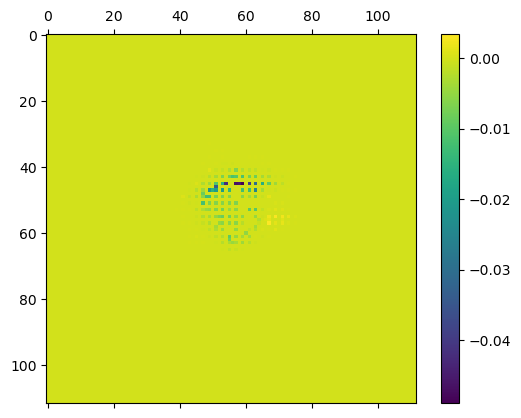

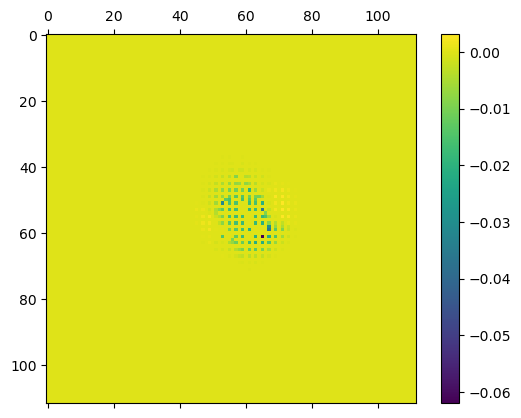

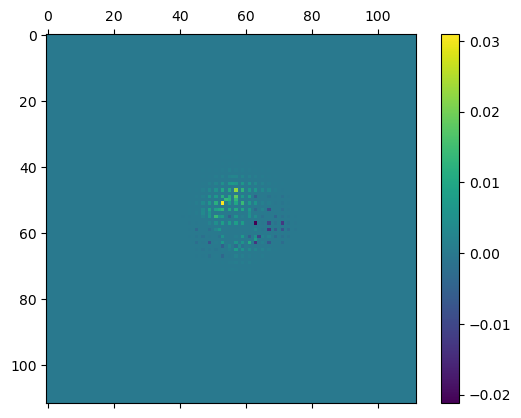

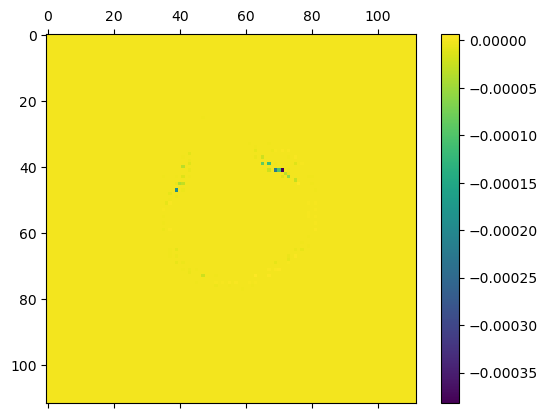

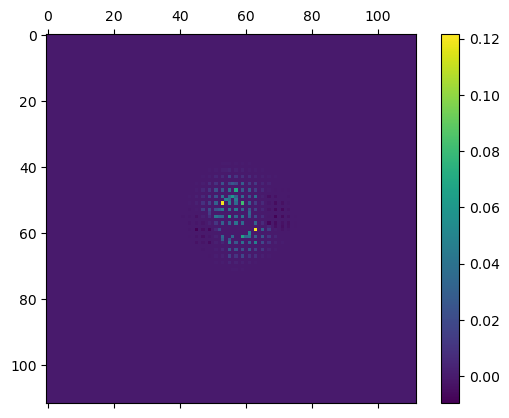

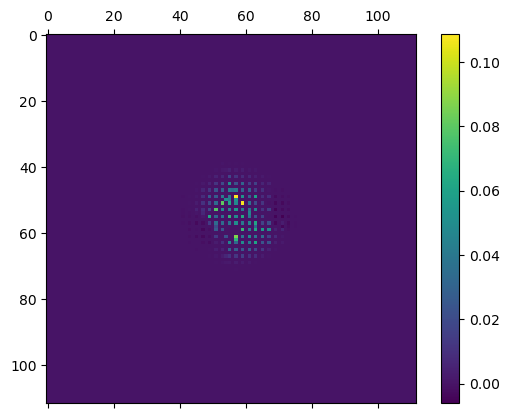

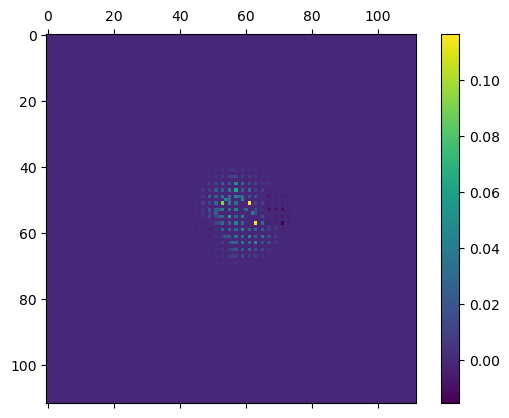

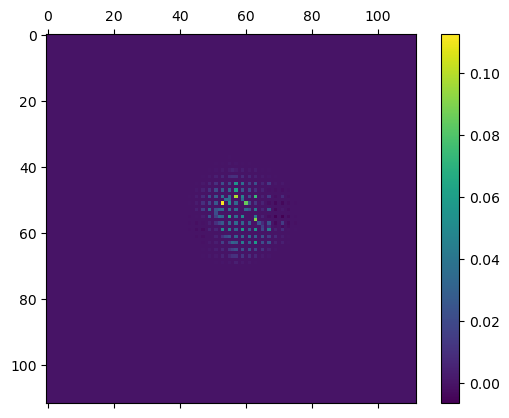

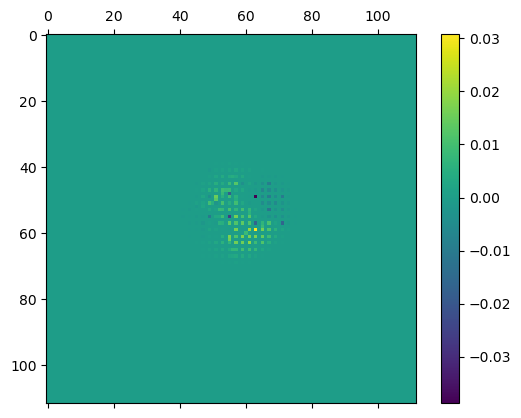

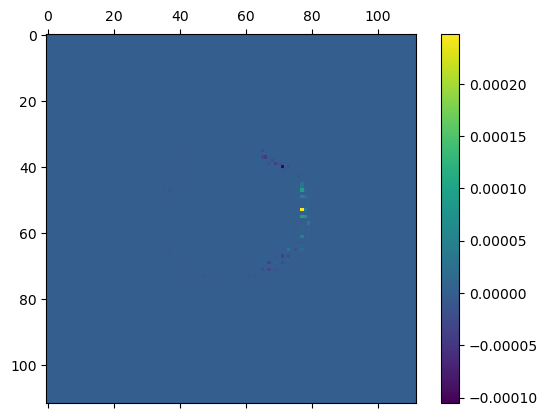

In [8]:
R=lrp.evaluate(sample2, mode='epsilon', depth=2)
R.shape

R_sum = np.zeros((112,112))

for ii in range(64):
    fig, axs = plt.subplots()
    heatmap = axs.matshow(R[:,ii,:,:].cpu().detach().numpy().squeeze())
    cbar = fig.colorbar(heatmap, ax=axs)
    plt.show()
    
    R_sum += R[:,ii,:,:].cpu().detach().numpy().squeeze()

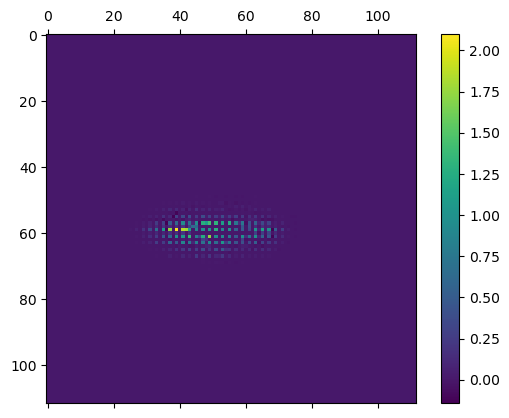

In [8]:
fig, axs = plt.subplots()
heatmap = axs.matshow(R_sum)
cbar = fig.colorbar(heatmap, ax=axs)
plt.show()

#### Save LRP on input Image to file

In [ ]:
# LRP-Epsilon
for sample in dataloader:

    R=lrp.evaluate(sample, mode='epsilon')
    R = R.cpu().detach().numpy().squeeze()

#     img = sample['image']
#     img = img.numpy().squeeze()
#     fig, axs = plt.subplots(2)
#     axs[0].matshow(img)
#     axs[1].matshow(R.cpu().detach().numpy().squeeze())
#     plt.show()

    # Original Image
    img_name = sample['img_name'][0]
    img = cv2.imread(img_name)
    # Get image name
    idx = img_name.find('Base')
    if idx == -1:
        idx = img_name.find('MPA')
    img_name1 = img_name[idx:]

    # Save Relevance as image
    R = cv2.resize(R, (img.shape[1], img.shape[0]))
    R = (R-np.min(R))/(np.max(R)-np.min(R))
    R = np.uint8(255*R)
    R = cv2.applyColorMap(R, cv2.COLORMAP_JET)
    cv2.imwrite('./analysis/lrp_epsilon/' + img_name1, R)

    # Save side by side as image
    img = sample['image']
    img = img.numpy().squeeze()
    fig, axs = plt.subplots(2)
    axs[0].matshow(img)
    axs[1].matshow(R)
    fig.savefig('./analysis/lrp_epsilon_side_by_side/' + img_name1)
    plt.close(fig)

In [ ]:
# LRP-Gamma.
for sample in dataloader:
    R=lrp.evaluate(sample, mode='gamma')
    R = R.cpu().detach().numpy().squeeze()

#     img = sample['image']
#     img = img.numpy().squeeze()
#     fig, axs = plt.subplots(2)
#     axs[0].matshow(img)
#     axs[1].matshow(R.cpu().detach().numpy().squeeze())
#     plt.show()
    
    # Original Image
    img_name = sample['img_name'][0]
    img = cv2.imread(img_name)
    # Get image name
    idx = img_name.find('layer')
    img_name1 = img_name[idx:]

    # Save Relevance as image
    R = cv2.resize(R, (img.shape[1], img.shape[0]))
    R = (R-np.min(R))/(np.max(R)-np.min(R))
    R = np.uint8(255*R)
    R = cv2.applyColorMap(R, cv2.COLORMAP_JET)
    cv2.imwrite('./analysis/lrp_gamma/' + img_name1, R)

## LRP on combined Image + PP NN

#### The NN model used for the combined NN

In [6]:
class MyModel(nn.Module):
    def __init__(self, imageModel, num_classes=10, num_param=10):
        super().__init__()
        self.ImageModel = imageModel
        self.paramLayer1 = nn.Sequential(nn.Linear(num_param, 10), nn.Sigmoid())
        self.paramLayer2 = nn.Sequential(nn.Linear(10, 10), nn.Sigmoid())
        self.paramLayer3 = nn.Sequential(nn.Linear(10, 10), nn.Sigmoid())
        self.paramLayer4 = nn.Sequential(nn.Linear(10, 10), nn.Sigmoid())
        self.fc_withParam = nn.Linear(512 + 10, num_classes)

        torch.nn.init.normal_(self.paramLayer1[0].weight)
        torch.nn.init.normal_(self.paramLayer2[0].weight)
        torch.nn.init.normal_(self.paramLayer3[0].weight)
        torch.nn.init.normal_(self.paramLayer4[0].weight)
        torch.nn.init.normal_(self.fc_withParam.weight)

    def forward(self, img, pp):
        # Image CNN
        x = self.ImageModel(img)

        # PP NN
        y = self.paramLayer1(pp)
        y = self.paramLayer2(y)
        y = self.paramLayer3(y)
        y = self.paramLayer4(y)
        y = y.view(y.size(0), -1)

        # Combine the process parameters with CNN results
#         y = torch.squeeze(y)  # remove any dimensions of 1
        z = torch.cat((x, y), dim=1)
        z = self.fc_withParam(z)
        return z

#### Implementation of LRP for this combined NN
##### Note: This implementation is model specific

In [7]:
class LRP_Combined(nn.Module):

    def __init__(self, model, eps=1.0e-9, gamma=0.1):
        super().__init__()
        self.model = model
        self.model.eval()

        self.eps = eps
        self.gamma = gamma
        self.layers = self.get_layers()

    def get_layers(self):

        # Builds list of all layers in the neural network
        # Works specifically for this CNN
        img_model_layers = nn.ModuleList()
        for module in self.model.ImageModel.children():
            if isinstance(module, nn.Sequential):
                for module2 in module.children():
                    # for module3 in module2.children():
                    #     if isinstance(module3, nn.Sequential):
                    #         for module4 in module3.children():
                    #             layers.append(module4)
                    #     else:
                    #         layers.append(module3)
                    img_model_layers.append(module2)
            else:
                img_model_layers.append(module)
        #         print(layers)

        param_layers = nn.ModuleList()
        final_layer = nn.ModuleList()
        for module in self.model.children():
            if not isinstance(module, torchvision.models.resnet.ResNet):
                if isinstance(module, nn.Sequential):
                    for module2 in module.children():
                        param_layers.append(module2)
                else:
                    final_layer.append(module)

        layers = {"image": img_model_layers, "pp": param_layers, "final": final_layer}
        return layers

    def evaluate(self, sample):
        img = sample['image']
        x = img.to(device=device, dtype=torch.float)
        pp = sample['process_parameters']
        y = pp.to(device=device, dtype=torch.float)

        img_act = []
        pp_act = []
        final_act = []

        with torch.no_grad():
            img_act.append(torch.ones_like(x))
            for layer in self.layers["image"]:
                #                 print(layer)
                if isinstance(layer, nn.Linear):
                    x = x.squeeze(dim=2)
                    x = x.squeeze(dim=2)
                x = layer(x)
                # print(x.shape)
                img_act.append(x)

            pp_act.append(torch.ones_like(pp))
            for layer in self.layers["pp"]:
                y = layer(y)
                pp_act.append(y)

            # y = y.view(y.size(0), -1)
            x = torch.squeeze(x)
            y = torch.squeeze(y)
            z = torch.cat((x, y), dim=-1)
            for layer in self.layers["final"]:
                z = layer(z)
                final_act.append(z)

        img_act = img_act[::-1]  # reverse order
        img_act = [a.requires_grad_(True) for a in img_act]

        pp_act = pp_act[::-1]
        pp_act = [a.requires_grad_(True) for a in pp_act]

        final_act = final_act[::-1]
        final_act = [a.requires_grad_(True) for a in final_act]

        if len(final_act) > 1:
            raise Exception("Not implemented")

        R = torch.softmax(final_act.pop(0), dim=-1)

        R_final_list = []
        R_final_list.append(R)

        img_layers = self.layers['image']
        pp_layers = self.layers['pp']
        final_layers = self.layers['final']

        reverse_img_layers = img_layers[::-1]
        reverse_pp_layers = pp_layers[::-1]

        act1 = img_act.pop(0)
        act2 = pp_act.pop(0)
        act2 = torch.squeeze(act2, dim=0)
        act = torch.cat((act1, act2), dim=1)

        R = self.lrp_eval(final_layers[0], act, R)
        R_final_list.append(R)

        R_img = R[0:512]
        R_img_list = []
        for layer in reverse_img_layers:
            R_img = self.lrp_eval(layer, img_act.pop(0), R_img)
            R_img_list.append(R_img)

        R_pp = R[512:]
        R_pp_list = []
        for layer in reverse_pp_layers:
            R_pp = self.lrp_eval(layer, pp_act.pop(0).to(device=device, dtype=torch.float), R_pp)
            R_pp_list.append(R_pp)

        return {"image": R_img_list, "pp": R_pp_list, "final": R_final_list}

    def lrp_eval(self, layer, a, R):
        if isinstance(layer, nn.Linear):
            a = a.squeeze()

        if isinstance(layer, nn.ReLU):
            return R

        a = a.data.requires_grad_(True)
        z = self.eps + layer.forward(a)
        s = (R / (z + 1e-9)).data  # 1e-9 to prevent divide by 0
        (z * s).sum().backward()
        c = a.grad
        R = a * c
        return R

#### Set up the model and LRP

In [8]:
num_classes = 8
num_param = 12

PATH = 'trained_models/CombinedNNepoch25_sigmoid_01_27_23.pth'

torch.cuda.empty_cache()

ImgModel = resnet18()
ImgModel.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
ImgModel.fc = nn.Linear(512, 512)
ImgModel.to(device)
model = MyModel(ImgModel, num_classes=num_classes, num_param=num_param)
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()

lrp_combined = LRP_Combined(model, eps=eps)

In [9]:
sample = next(iter(dataloader))

R_dict =lrp_combined.evaluate(sample)

In [11]:
lrp_combined.evaluate(sample)

{'image': [tensor([-0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00, -5.7295e-04,  0.0000e+00,  0.0000e+00,
           0.0000e+00, -5.0402e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
          -0.0000e+00,  7.5825e-05,  4.2537e-08,  0.0000e+00, -0.0000e+00,
           0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
           0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00,
           0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
           0.0000e+00,  0.0000e+00, -0.0000e+00,  1.2480e-05, -0.0000e+00,
           0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
           0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00, -4.3083e-04,  0.0000e+00,
           8.490

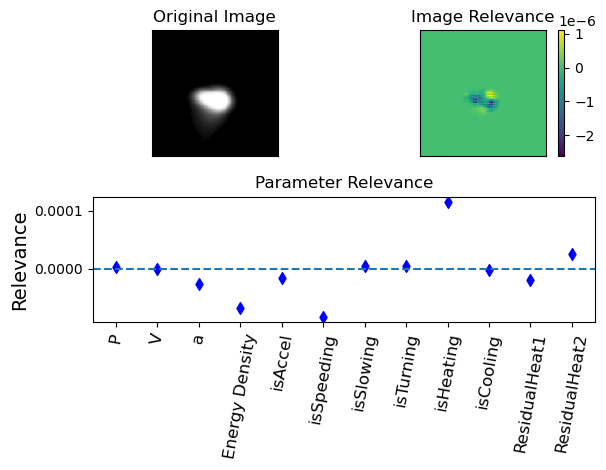

In [34]:
sample = next(iter(dataloader))

R_dict =lrp_combined.evaluate(sample)

img = sample['image']
img = img.numpy().squeeze()
img = np.uint8(255*img)
img = np.stack((img,img,img), 2)
pp = sample['process_parameters']
label = sample['label'].item()

R_img_list = R_dict["image"]
R_img = R_img_list[-1]

R_pp_list = R_dict["pp"]
R_pp = R_pp_list[-1]
# print(R_pp)
# print(R_img.max())

# fig, axs = plt.subplots(2,2)
# axs[0,0].matshow(img)
# axs[0,1].matshow(R_img.cpu().detach().numpy().squeeze())
# plt.show()

images = sample['image']
process_parameters = sample['process_parameters']
images = images.to(device=device, dtype=torch.float)
process_parameters = process_parameters.to(device=device, dtype=torch.float)
with torch.set_grad_enabled(False):
        outputs = model(images, process_parameters)
        _, preds = torch.max(outputs, 1)

fig, axs = plt.subplot_mosaic([['left', 'right'],['bottom', 'bottom']])
axs['left'].matshow(img)
# axs['left'].title.set_text("GT: " + str(label) + ", Pred: " + str(preds.item()))
axs['left'].title.set_text("Original Image")
axs['left'].set_xticks([])
axs['left'].set_yticks([])
axs['left'].set_xticklabels([])
axs['left'].set_yticklabels([])

heatmap = axs['right'].matshow(R_img.cpu().detach().numpy().squeeze())
cbar = fig.colorbar(heatmap, ax=axs['right'])
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
axs['right'].title.set_text('Image Relevance')
axs['right'].set_xticks([])
axs['right'].set_yticks([])
axs['right'].set_xticklabels([])
axs['right'].set_yticklabels([])

axs['bottom'].scatter(np.arange(12), R_pp.cpu().detach().numpy(), color="blue", marker="d")
axs['bottom'].set_ylabel("Relevance",fontsize=14)
# axs['bottom'].set_ylabel("Relevance",color="blue",fontsize=14)
axs['bottom'].axhline(0, linestyle='dashed')

# ax2 = axs['bottom'].twinx()
# ax2.scatter(np.arange(12), pp, c="orange", marker="d")
# ax2.set_yticks([-1.0, -0.5, 0, 0.5, 1])
# ax2.set_ylabel("PP Value",color="orange",fontsize=14)

axs['bottom'].title.set_text('Parameter Relevance')
pp_labels = ('P','V','a', 'Energy Density','isAccel','isSpeeding','isSlowing',
             'isTurning', 'isHeating','isCooling','ResidualHeat1', 'ResidualHeat2')
axs['bottom'].set_xticks(np.arange(12))
axs['bottom'].set_xticklabels(pp_labels, rotation=80, fontdict={'fontsize': 12})
fig.tight_layout()
# plt.savefig('PaperFiles/LRP_Image2', dpi=800)
plt.show()

In [26]:
R_pp_list

[tensor([[[ 6.0020e-03,  1.6333e-05, -6.8825e-03,  3.9992e-06,  2.2859e-04,
           -1.9262e-04, -1.8220e-04,  4.0924e-04, -3.8954e-03,  7.6134e-03]]],
        device='cuda:0', grad_fn=<MulBackward0>),
 tensor([ 9.8871e-06,  5.0535e-04,  3.8257e-03, -9.2856e-04,  1.2833e-03,
         -6.7775e-04, -5.5977e-03,  2.0312e-03,  1.4047e-03, -1.1293e-03],
        device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[[-1.7132e-06, -1.0343e-05,  1.1401e-04,  1.7500e-05, -2.4628e-04,
           -4.7669e-05, -2.4134e-04,  2.4335e-04, -6.9518e-05, -1.3665e-04]]],
        device='cuda:0', grad_fn=<MulBackward0>),
 tensor([-4.1307e-05, -1.4670e-05, -1.0803e-04, -2.6195e-04, -1.4370e-05,
          1.4587e-04, -4.1057e-06,  3.0123e-06, -3.3548e-04, -4.0943e-05],
        device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[[ 7.8290e-06,  2.5665e-07,  7.3273e-06, -4.2372e-06,  2.3411e-06,
            1.7570e-05,  1.4747e-07, -1.7559e-07, -1.3422e-05, -4.2656e-08]]],
        device='cuda:0', grad_fn=<Mul

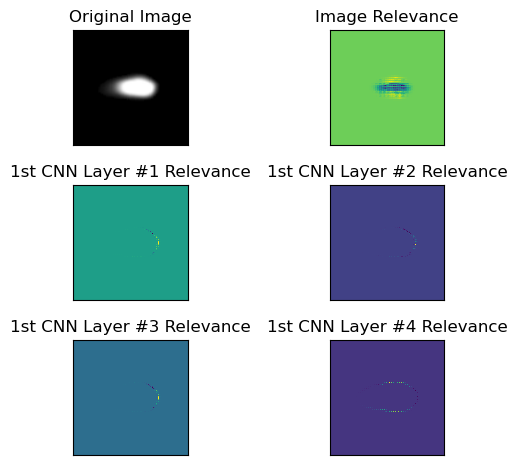

In [11]:
R_img_list = R_dict["image"]
R_img = R_img_list[-1]
R_2 = np.squeeze(R_img_list[-2].cpu().detach().numpy())
R_2_sum = np.sum(R_2, axis=(1,2))
max_indx = np.argsort(R_2_sum)
img = sample['image']
img = img.numpy().squeeze()
img = np.uint8(255*img)
img = np.stack((img,img,img), 2)

fig, axs = plt.subplot_mosaic([['t_left', 't_right'],['m_left', 'm_right'],['b_left', 'b_right']])

axs['t_left'].matshow(img)
axs['t_left'].title.set_text('Original Image')
axs['t_left'].set_xticks([])
axs['t_left'].set_yticks([])
axs['t_left'].set_xticklabels([])
axs['t_left'].set_yticklabels([])

axs['t_right'].matshow(R_img.cpu().detach().numpy().squeeze())
axs['t_right'].title.set_text('Image Relevance')
axs['t_right'].set_xticks([])
axs['t_right'].set_yticks([])
axs['t_right'].set_xticklabels([])
axs['t_right'].set_yticklabels([])

axs['m_left'].matshow(R_2[max_indx[-1],:,:])
axs['m_left'].title.set_text('1st CNN Layer #1 Relevance')
axs['m_left'].set_xticks([])
axs['m_left'].set_yticks([])
axs['m_left'].set_xticklabels([])
axs['m_left'].set_yticklabels([])

axs['m_right'].matshow(R_2[max_indx[-2],:,:])
axs['m_right'].title.set_text('1st CNN Layer #2 Relevance')
axs['m_right'].set_xticks([])
axs['m_right'].set_yticks([])
axs['m_right'].set_xticklabels([])
axs['m_right'].set_yticklabels([])

axs['b_left'].matshow(R_2[max_indx[-3],:,:])
axs['b_left'].title.set_text('1st CNN Layer #3 Relevance')
axs['b_left'].set_xticks([])
axs['b_left'].set_yticks([])
axs['b_left'].set_xticklabels([])
axs['b_left'].set_yticklabels([])

axs['b_right'].matshow(R_2[max_indx[-4],:,:])
axs['b_right'].title.set_text('1st CNN Layer #4 Relevance')
axs['b_right'].set_xticks([])
axs['b_right'].set_yticks([])
axs['b_right'].set_xticklabels([])
axs['b_right'].set_yticklabels([])

fig.tight_layout()
plt.savefig('test.png')
plt.show()

#### Save LRP outputs to file

In [ ]:
# LRP-Epsilon
counter = 0
for sample in dataloader:
    if np.mod(counter, 500) == 0:
        print(counter, '/', len(dataloader))
    counter += 1
    
    pp = sample['process_parameters']
    
    img_name = sample['img_name'][0]
    idx = img_name.find('Base')
    if idx == -1:
        idx = img_name.find('MPA')
    img_name1 = img_name[idx:]
    if os.path.exists('./analysis/lrp_epsilon_combined_sigmoid_side_by_side/' + img_name1):
        continue
        
    R_dict =lrp_combined.evaluate(sample)

    img = sample['image']
    img = img.numpy().squeeze()
    img = np.uint8(255*img)
    img = np.stack((img,img,img), 2)
    
    label = sample['label'].item()

    R_img_list = R_dict["image"]
    R_img = R_img_list[-1]

    R_pp_list = R_dict["pp"]
    R_pp = R_pp_list[-1]

    # Original Image
    img_name = sample['img_name'][0]
    orig_img = cv2.imread(img_name)
    # Get image name
    idx = img_name.find('Base')
    if idx == -1:
        idx = img_name.find('MPA')
    img_name1 = img_name[idx:]

    images = sample['image']
    process_parameters = sample['process_parameters']
    images = images.to(device=device, dtype=torch.float)
    process_parameters = process_parameters.to(device=device, dtype=torch.float)
    with torch.set_grad_enabled(False):
        outputs = model(images, process_parameters)
        _, preds = torch.max(outputs, 1)
    
    fig, axs = plt.subplot_mosaic([['left', 'right'],['bottom', 'bottom']])
    axs['left'].matshow(img)
    axs['left'].title.set_text("GT: " + str(label) + ", Pred: " + str(preds.item()))
    axs['left'].set_xticks([])
    axs['left'].set_yticks([])
    axs['left'].set_xticklabels([])
    axs['left'].set_yticklabels([])

    heatmap = axs['right'].matshow(R_img.cpu().detach().numpy().squeeze())
    cbar = fig.colorbar(heatmap, ax=axs['right'])
    axs['right'].title.set_text('Image Relevance')
    axs['right'].set_xticks([])
    axs['right'].set_yticks([])
    axs['right'].set_xticklabels([])
    axs['right'].set_yticklabels([])

    axs['bottom'].bar(np.arange(12), R_pp.cpu().detach().numpy(), color="blue")
    axs['bottom'].set_ylabel("Relevance",color="blue",fontsize=14)
    
    ax2 = axs['bottom'].twinx()
    ax2.scatter(np.arange(12), pp, c="orange", marker="d")
    ax2.set_yticks([-1.0, -0.5, 0, 0.5, 1])
    ax2.set_ylabel("PP Value",color="orange",fontsize=14)
    axs['bottom'].title.set_text('Parameter Relevance')
    pp_labels = ('P','V','a', 'Energy Density','isAccel','isSpeeding','isSlowing',
             'isTurning', 'isHeating','isCooling','closeness1', 'closeness2')
    axs['bottom'].set_xticks(np.arange(12))
    axs['bottom'].set_xticklabels(pp_labels, rotation=90)
    plt.tight_layout()
    fig.savefig('./analysis/lrp_epsilon_combined_sigmoid_side_by_side/' + img_name1)
    if (label != preds.item()):
        fig.savefig('./analysis/lrp_epsilon_combined_sigmoid_side_by_side_incorrect/' + img_name1)
    plt.close(fig)

#### Save LRP input image and 1st CNN layers to file

In [ ]:
# LRP-Epsilon
counter = 0
for sample in dataloader:
    if np.mod(counter, 500) == 0:
        print(counter, '/', len(dataloader))
    counter += 1
    
    img_name = sample['img_name'][0]
    idx = img_name.find('layer')
    img_name1 = img_name[idx:]
    if os.path.exists('./analysis/lrp_epsilon_combined_layer1/' + img_name1):
        continue
        
    R_dict =lrp_combined.evaluate(sample)

    img = sample['image']
    img = img.numpy().squeeze()
    img = np.uint8(255*img)
    img = np.stack((img,img,img), 2)

    R_img_list = R_dict["image"]
    R_img = R_img_list[-1]

    R_pp_list = R_dict["pp"]
    R_pp = R_pp_list[-1]

    # Original Image
    img_name = sample['img_name'][0]
#     orig_img = cv2.imread(img_name)
    # Get image name
    idx = img_name.find('layer')
    img_name1 = img_name[idx:]
    
    # 1st CNN Layer info
    R_img_list = R_dict["image"]
    R_img = R_img_list[-1]
    R_2 = np.squeeze(R_img_list[-2].cpu().detach().numpy())
    R_2_sum = np.sum(R_2, axis=(1,2))
    max_indx = np.argsort(R_2_sum)

    fig, axs = plt.subplot_mosaic([['t_left', 't_right'],['m_left', 'm_right'],['b_left', 'b_right']])

    axs['t_left'].matshow(img)
    axs['t_left'].title.set_text('Original Image')
    axs['t_left'].set_xticks([])
    axs['t_left'].set_yticks([])
    axs['t_left'].set_xticklabels([])
    axs['t_left'].set_yticklabels([])

    axs['t_right'].matshow(R_img.cpu().detach().numpy().squeeze())
    axs['t_right'].title.set_text('Image Relevance')
    axs['t_right'].set_xticks([])
    axs['t_right'].set_yticks([])
    axs['t_right'].set_xticklabels([])
    axs['t_right'].set_yticklabels([])

    axs['m_left'].matshow(R_2[max_indx[-1],:,:])
    axs['m_left'].title.set_text('1st CNN Layer #1 Relevance')
    axs['m_left'].set_xticks([])
    axs['m_left'].set_yticks([])
    axs['m_left'].set_xticklabels([])
    axs['m_left'].set_yticklabels([])

    axs['m_right'].matshow(R_2[max_indx[-2],:,:])
    axs['m_right'].title.set_text('1st CNN Layer #2 Relevance')
    axs['m_right'].set_xticks([])
    axs['m_right'].set_yticks([])
    axs['m_right'].set_xticklabels([])
    axs['m_right'].set_yticklabels([])

    axs['b_left'].matshow(R_2[max_indx[-3],:,:])
    axs['b_left'].title.set_text('1st CNN Layer #3 Relevance')
    axs['b_left'].set_xticks([])
    axs['b_left'].set_yticks([])
    axs['b_left'].set_xticklabels([])
    axs['b_left'].set_yticklabels([])

    axs['b_right'].matshow(R_2[max_indx[-4],:,:])
    axs['b_right'].title.set_text('1st CNN Layer #4 Relevance')
    axs['b_right'].set_xticks([])
    axs['b_right'].set_yticks([])
    axs['b_right'].set_xticklabels([])
    axs['b_right'].set_yticklabels([])
    
    plt.tight_layout()
    fig.savefig('./analysis/lrp_epsilon_combined_layer1/' + img_name1)
    plt.close(fig)

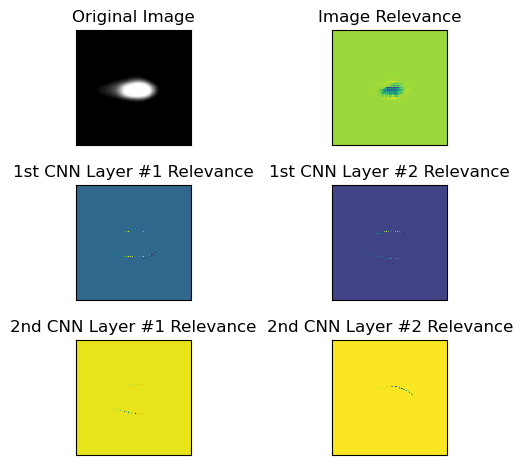

In [14]:
R_img_list = R_dict["image"]
R_img = R_img_list[-1]
R_2 = np.squeeze(R_img_list[-2].cpu().detach().numpy())
R_2_sum = np.sum(R_2, axis=(1,2))
max_indx_2 = np.argsort(R_2_sum)

R_3 = np.squeeze(R_img_list[-3].cpu().detach().numpy())
R_3_sum = np.sum(R_3, axis=(1,2))
max_indx_3 = np.argsort(R_3_sum)

img = sample['image']
img = img.numpy().squeeze()
img = np.uint8(255*img)
img = np.stack((img,img,img), 2)

fig, axs = plt.subplot_mosaic([['t_left', 't_right'],['m_left', 'm_right'],['b_left', 'b_right']])

axs['t_left'].matshow(img)
axs['t_left'].title.set_text('Original Image')
axs['t_left'].set_xticks([])
axs['t_left'].set_yticks([])
axs['t_left'].set_xticklabels([])
axs['t_left'].set_yticklabels([])

axs['t_right'].matshow(R_img.cpu().detach().numpy().squeeze())
axs['t_right'].title.set_text('Image Relevance')
axs['t_right'].set_xticks([])
axs['t_right'].set_yticks([])
axs['t_right'].set_xticklabels([])
axs['t_right'].set_yticklabels([])

axs['m_left'].matshow(R_2[max_indx_2[-1],:,:])
axs['m_left'].title.set_text('1st CNN Layer #1 Relevance')
axs['m_left'].set_xticks([])
axs['m_left'].set_yticks([])
axs['m_left'].set_xticklabels([])
axs['m_left'].set_yticklabels([])

axs['m_right'].matshow(R_2[max_indx_2[-2],:,:])
axs['m_right'].title.set_text('1st CNN Layer #2 Relevance')
axs['m_right'].set_xticks([])
axs['m_right'].set_yticks([])
axs['m_right'].set_xticklabels([])
axs['m_right'].set_yticklabels([])

axs['b_left'].matshow(R_3[max_indx_3[-1],:,:])
axs['b_left'].title.set_text('2nd CNN Layer #1 Relevance')
axs['b_left'].set_xticks([])
axs['b_left'].set_yticks([])
axs['b_left'].set_xticklabels([])
axs['b_left'].set_yticklabels([])

axs['b_right'].matshow(R_3[max_indx_3[-2],:,:])
axs['b_right'].title.set_text('2nd CNN Layer #2 Relevance')
axs['b_right'].set_xticks([])
axs['b_right'].set_yticks([])
axs['b_right'].set_xticklabels([])
axs['b_right'].set_yticklabels([])

fig.tight_layout()
plt.savefig('test.png')
plt.show()

### Analyze the PP 

In [10]:
# LRP-Epsilon
pp_array = np.zeros((8, 12))
ed_list = [list(), list(), list(), list(), list(), list(), list(), list()]
pp_counts = np.zeros(8)
importance_array = np.zeros((8,12))

counter = 0
for sample in dataloader:
    if np.mod(counter, 250) == 0:
        print(counter, '/', len(dataloader))
    counter += 1    
        
    R_dict =lrp_combined.evaluate(sample)
    
    R_img_list = R_dict["image"]
    R_img = R_img_list[-1]

    R_pp_list = R_dict["pp"]
    R_pp = R_pp_list[-1]
    
#     if np.max(R_pp.detach().cpu().numpy()) > 1:
#         img_name = sample['img_name'][0]
#         print(R_pp)
    
    pp = sample['process_parameters'][0][0]

    
    images = sample['image']
    process_parameters = sample['process_parameters']
    images = images.to(device=device, dtype=torch.float)
    process_parameters = process_parameters.to(device=device, dtype=torch.float)
    with torch.set_grad_enabled(False):
        outputs = model(images, process_parameters)
        _, preds = torch.max(outputs, 1)
        
        pp_array[preds,:] += pp.numpy()
        pp_counts[preds] += 1
        importance_array[preds,:] += R_pp.cpu().numpy()
        ed_list[preds].append(pp.numpy()[10])

0 / 6308
250 / 6308
500 / 6308
750 / 6308
1000 / 6308
1250 / 6308
1500 / 6308
1750 / 6308
2000 / 6308
2250 / 6308
2500 / 6308
2750 / 6308
3000 / 6308
3250 / 6308
3500 / 6308
3750 / 6308
4000 / 6308
4250 / 6308
4500 / 6308
4750 / 6308
5000 / 6308
5250 / 6308
5500 / 6308
5750 / 6308
6000 / 6308
6250 / 6308


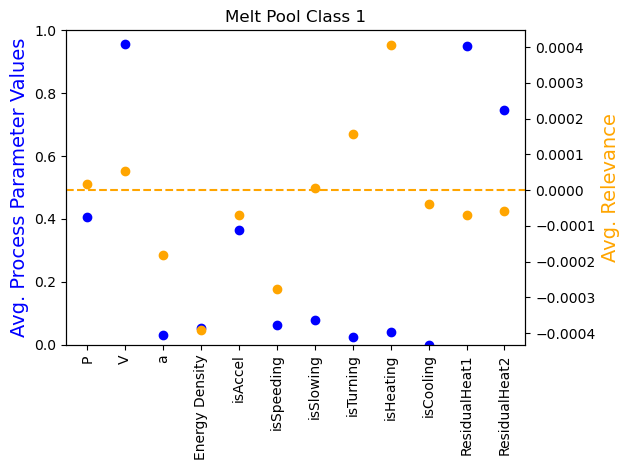

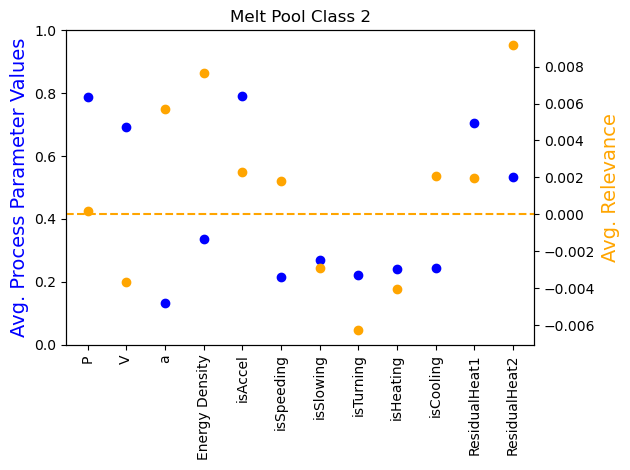

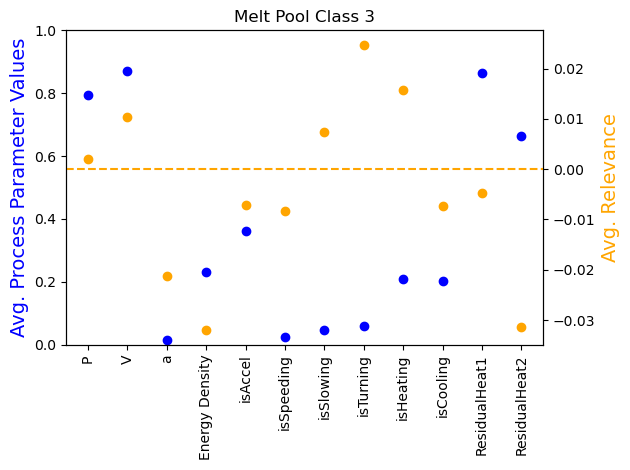

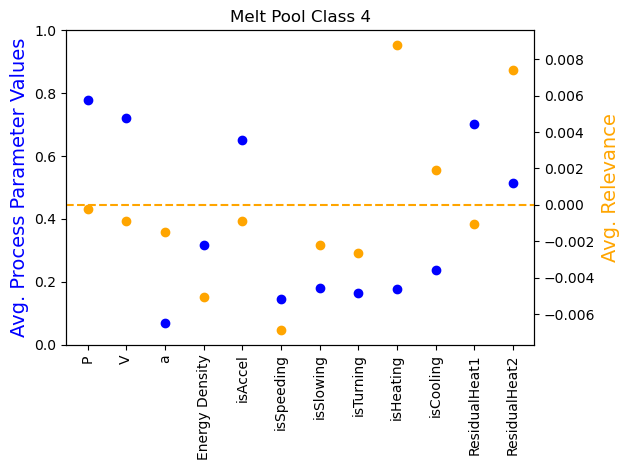

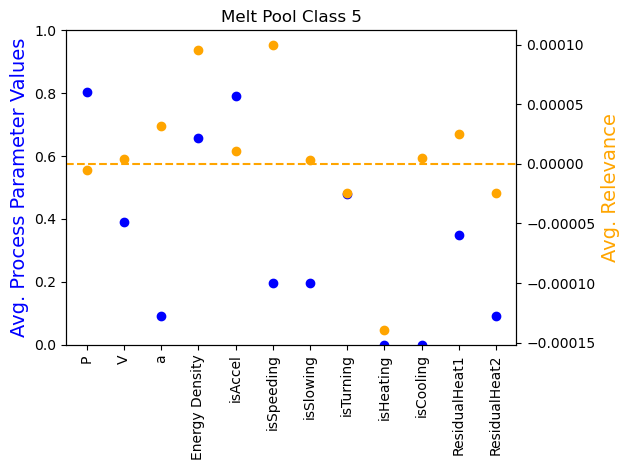

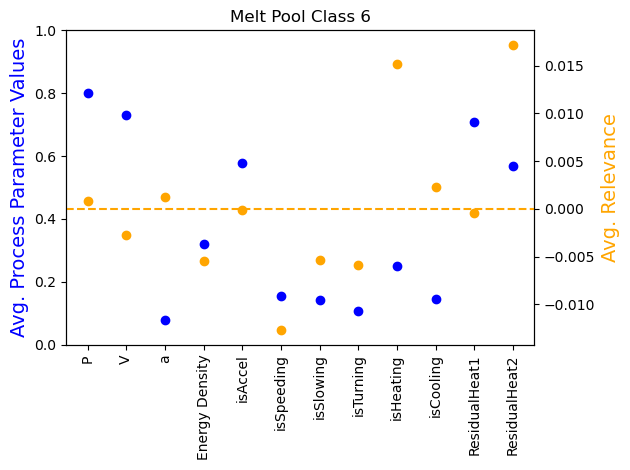

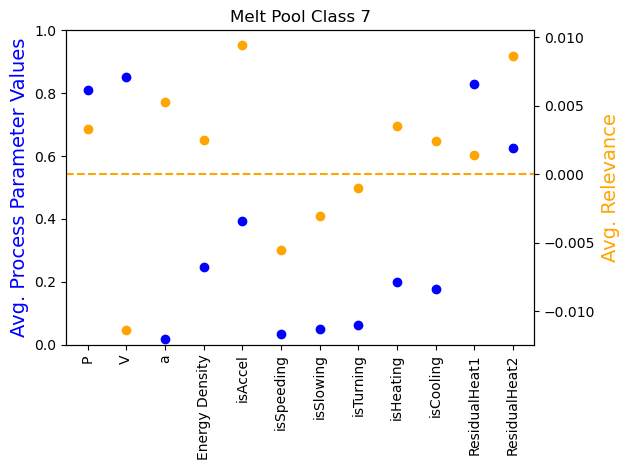

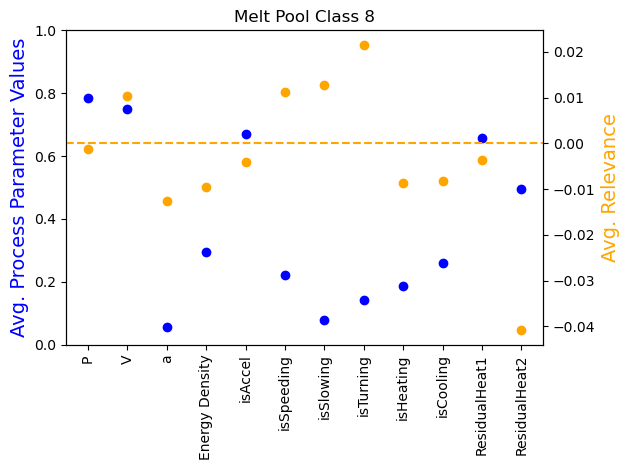

In [11]:
pp_avg = np.zeros((8, 12))
importance_avg = np.zeros((8,12))
for ii in range(8):
    pp_avg[ii,:] = pp_array[ii,:] / pp_counts[ii]
    importance_avg[ii, :] = importance_array[ii,:] / pp_counts[ii]
#     pp_avg[ii, 3] = 1
pp_avg

for ii in range(8):    
    fig, ax = plt.subplots()
    ax.scatter(range(12), pp_avg[ii, :], color="blue")
    ax2 = ax.twinx()
    
    ax2.scatter(range(12), importance_avg[ii,:], color="orange")
    ax2.axhline(0, linestyle='dashed', color="orange")
    ax.set_xticks(np.arange(12))
    pp_labels = ('P','V','a', 'Energy Density','isAccel','isSpeeding','isSlowing',
             'isTurning', 'isHeating','isCooling','ResidualHeat1', 'ResidualHeat2')
    ax.set_xticklabels(pp_labels, rotation=90)
    ax.set_ylabel("Avg. Process Parameter Values",color="blue",fontsize=14)
    ax.set_ylim([0, 1])
    ax2.set_ylabel("Avg. Relevance",color="orange",fontsize=14)
    plt.title('Melt Pool Class ' + str(ii+1))
    plt.tight_layout()
    plt.savefig('PaperFiles/PP_Rel_Analysis/PP_relevance_class'+str(ii), dpi=800)
    plt.show()

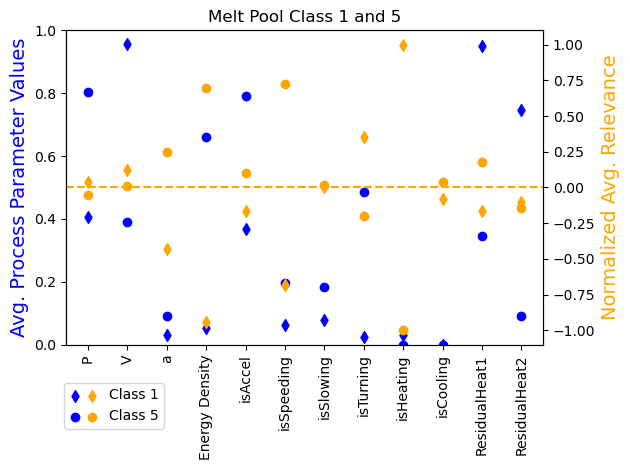

In [52]:
# Combine results for melt pool class 1 and 5

fig, ax = plt.subplots()
p1 = ax.scatter(range(12), pp_avg[0, :], color="blue", marker='d', label='_pp1')
p2 = ax.scatter(range(12), pp_avg[4, :], color="blue", label='_pp2')
ax2 = ax.twinx()
r1 = ax2.scatter(range(12), importance_avg[0,:]/np.max(np.abs(importance_avg[0,:])), color="orange", marker='d', label='Class 1')
r2 = ax2.scatter(range(12), importance_avg[4,:]/np.max(np.abs(importance_avg[4,:])), color="orange", label='Class 5')
ax2.axhline(0, linestyle='dashed', color="orange", label='_horizontal line')
ax.set_xticks(np.arange(12))
ax.set_ylim([0, 1])
ax.set_xticklabels(pp_labels, rotation=90)
ax.set_ylabel("Avg. Process Parameter Values",color="blue",fontsize=14)
ax2.set_ylabel("Normalized Avg. Relevance",color="orange",fontsize=14)

plt.title('Melt Pool Class 1 and 5')
plt.legend([(p1, r1), (p2, r2)], ['Class 1', 'Class 5'], loc='upper center', bbox_to_anchor=(0.1,-0.1), handler_map={tuple: HandlerTuple(ndivide=None)})
# plt.legend()
plt.tight_layout()
plt.savefig('PaperFiles/PP_Rel_Analysis/PP_relevance_class1_5', dpi=800)
plt.show()

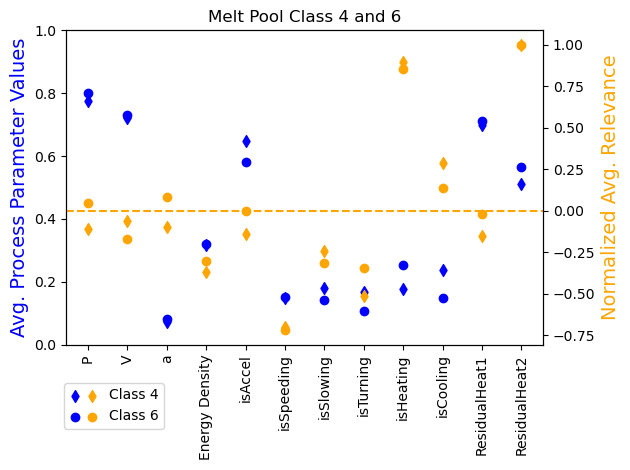

In [53]:
# Combine results for melt pool class 4 and 6

fig, ax = plt.subplots()
p1 = ax.scatter(range(12), pp_avg[3, :], color="blue", marker='d', label='_pp1')
p2 = ax.scatter(range(12), pp_avg[5, :], color="blue", label='_pp2')
ax2 = ax.twinx()
a1 = ax2.scatter(range(12), importance_avg[3,:]/np.max(np.abs(importance_avg[3,:])), color="orange", marker='d', label='Class 4')
a2 = ax2.scatter(range(12), importance_avg[5,:]/np.max(np.abs(importance_avg[5,:])), color="orange", label='Class 6')
ax2.axhline(0, linestyle='dashed', color="orange", label='_horizontal line')
ax.set_xticks(np.arange(12))
ax.set_ylim([0, 1])
ax.set_xticklabels(pp_labels, rotation=90)
ax.set_ylabel("Avg. Process Parameter Values",color="blue",fontsize=14)
ax2.set_ylabel("Normalized Avg. Relevance",color="orange",fontsize=14)

plt.title('Melt Pool Class 4 and 6')
plt.legend([(p1, r1), (p2, r2)], ['Class 4', 'Class 6'], loc='upper center', bbox_to_anchor=(0.1,-0.1), handler_map={tuple: HandlerTuple(ndivide=None)})
plt.tight_layout()
plt.savefig('PaperFiles/PP_Rel_Analysis/PP_relevance_class4_6', dpi=800)
plt.show()

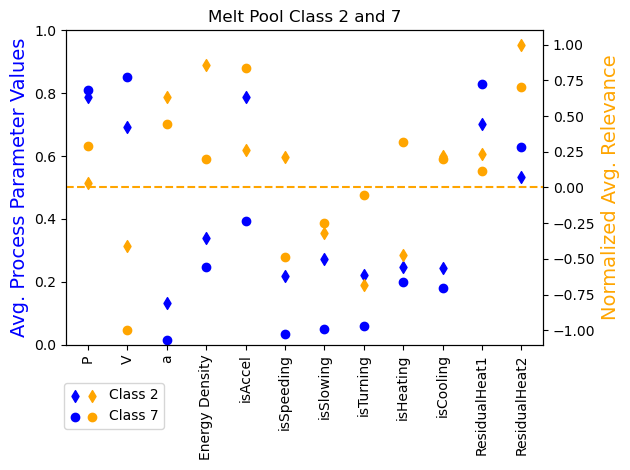

In [54]:
# Combine results for melt pool class 2 and 7

fig, ax = plt.subplots()
p1 = ax.scatter(range(12), pp_avg[1, :], color="blue", marker='d', label='_pp1')
p2 = ax.scatter(range(12), pp_avg[6, :], color="blue", label='_pp2')
ax2 = ax.twinx()
a1 = ax2.scatter(range(12), importance_avg[1,:]/np.max(np.abs(importance_avg[1,:])), color="orange", marker='d', label='Class 2')
a2 = ax2.scatter(range(12), importance_avg[6,:]/np.max(np.abs(importance_avg[6,:])), color="orange", label='Class 7')
ax2.axhline(0, linestyle='dashed', color="orange", label='_horizontal line')
ax.set_xticks(np.arange(12))
ax.set_ylim([0, 1])
ax.set_xticklabels(pp_labels, rotation=90)
ax.set_ylabel("Avg. Process Parameter Values",color="blue",fontsize=14)
ax2.set_ylabel("Normalized Avg. Relevance",color="orange",fontsize=14)

plt.title('Melt Pool Class 2 and 7')
plt.legend([(p1, r1), (p2, r2)], ['Class 2', 'Class 7'], loc='upper center', bbox_to_anchor=(0.1,-0.1), handler_map={tuple: HandlerTuple(ndivide=None)})
plt.tight_layout()
plt.savefig('PaperFiles/PP_Rel_Analysis/PP_relevance_class2_7', dpi=800)
plt.show()

In [46]:
base_labels = np.squeeze(pd.read_excel('Preprocessed Images/BaseLabels.xlsx', header=None, engine='openpyxl').to_numpy())
mpa_labels = np.squeeze(pd.read_excel('Preprocessed Images/MPALabels.xlsx', header=None, engine='openpyxl').to_numpy())
base_pp = np.squeeze(pd.read_excel('Preprocessed Images/BasePP.xlsx', header=None, engine='openpyxl').to_numpy())
mpa_pp  = np.squeeze(pd.read_excel('Preprocessed Images/MPAPP.xlsx', header=None, engine='openpyxl').to_numpy())

In [61]:
changed_indx = np.where(~np.equal(base_labels, mpa_labels))[0]
unchanged_indx = np.where(np.equal(base_labels, mpa_labels))[0]

In [62]:
base_labels

array([0, 0, 5, ..., 5, 5, 5], dtype=int64)

In [54]:
base_changed = base_labels[changed_indx]
mpa_changed  = mpa_labels[changed_indx]

pp_change = mpa_pp-base_pp
pp_change = pp_change[changed_indx]

num_changed = len(base_changed)

In [59]:
comparison = np.zeros((8,8))
P_change = np.zeros((8,8))
for ii in range(num_changed):
    comparison[base_changed[ii]][mpa_changed[ii]] += 1
    P_change[base_changed[ii]][mpa_changed[ii]] += pp_change[ii, 2]
P_change = np.divide(P_change, comparison) 
comparison

C:\Users\satom\anaconda3\envs\autoencoder\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


array([[  0.,  46., 332.,  77.,   0.,  30., 351.,  31.],
       [  2.,   0., 112.,  91.,   0., 193.,  39.,   7.],
       [ 19., 240.,   0.,  11.,   0., 194.,   0., 260.],
       [  0., 127.,  17.,   0.,   0., 146., 652.,  94.],
       [  0., 136.,  32., 208.,   0.,  28.,   4.,  83.],
       [  0., 295., 217., 143.,   0.,   0., 201., 352.],
       [  7.,  40.,   0., 223.,   0., 177.,   0.,   1.],
       [  0.,  17., 195.,  92.,   0., 193.,   0.,   0.]])

In [43]:
# Changed to
np.sum(comparison, axis=0)

array([  28.,  901.,  905.,  845.,    0.,  961., 1247.,  828.])

In [44]:
# Changed from
np.sum(comparison, axis=1)

array([ 867.,  444.,  724., 1036.,  491., 1208.,  448.,  497.])

In [60]:
P_change

array([[          nan,  127.88347826,  126.42445783,  128.06714286,
                  nan,  130.40266667,  131.65364672,  124.24967742],
       [ -97.995     ,           nan,   -1.89276786,  -15.27692308,
                  nan,   -4.73948187,    0.89589744,   16.34571429],
       [ -98.45789474,  -20.34541667,           nan,  -36.16909091,
                  nan,  -35.46108247,           nan,  -14.00726923],
       [          nan,  -21.80645669,   -5.51235294,           nan,
                  nan,  -26.87547945,  -17.9657362 ,  -21.49468085],
       [          nan, -120.42455882, -118.73996875, -125.47740865,
                  nan, -122.97375   , -111.83      , -106.20137349],
       [          nan,   32.26294915,   27.0035023 ,   45.6348951 ,
                  nan,           nan,   29.81084577,   25.80122159],
       [-104.88857143,    9.69825   ,           nan,   13.15026906,
                  nan,  -25.82305085,           nan,   42.32      ],
       [          nan,  -26.61235294,   -

In [65]:
base_unchanged = base_labels[unchanged_indx]
mpa_unchanged  = mpa_labels[unchanged_indx]

pp_unchanged = mpa_pp-base_pp
pp_unchanged = pp_unchanged[unchanged_indx]

num_unchanged = len(base_unchanged)

unchanged_comparison = np.zeros((8))
P_unchanged = np.zeros((8))
for ii in range(num_unchanged):
    unchanged_comparison[base_unchanged[ii]] += 1
    P_unchanged[base_unchanged[ii]] += pp_unchanged[ii, 2]
P_unchanged = np.divide(P_unchanged, unchanged_comparison)
unchanged_comparison

C:\Users\satom\anaconda3\envs\autoencoder\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


array([   6., 1113., 4294., 1762.,    0., 1211., 5770., 1032.])

In [66]:
P_unchanged

array([-71.81066667,  -6.98530997,  -8.90645785, -11.53198468,
                nan,  17.70390586,   3.11707452, -12.70840116])